In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats
import itertools as itertls

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    if use_scatter:
        ax.scatter(x, y, marker="o", color="tab:blue", s=15)

    ax.plot(x, y)

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


## Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,46
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


*Encoding*

In [7]:
df_cdb_enc = df_cdb_with_tipe.copy()

categorical_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Pengeluaran", "Pendidikan", "initial Varian Plus", "Tipe Pembeli"]

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_cdb_enc[col] = le.fit_transform(df_cdb_enc[col])
    label_encoders[col] = le

df_cdb_enc

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,41,3,0,1996-08-18,18,3,5,LD0,4,0,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,51,7,1,2003-04-14,10,0,0,LP0,4,0,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,204,5,1,1997-02-13,14,6,2,LPA,4,0,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,212,4,1,1982-11-16,9,5,4,LP0,4,0,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,43,4,0,1976-01-17,10,4,4,LPA,4,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,116,6,0,2004-11-06,10,6,4,MM0,5,0,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,51,7,1,1978-03-21,10,3,4,MM0,5,0,46
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,71,5,0,1961-01-19,10,3,2,LP3,4,0,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,212,4,1,1980-04-30,2,2,4,ML0,5,0,44


In [8]:
label_mappings = []

for col, le in label_encoders.items():
    for index, class_name in enumerate(le.classes_):
        label_mappings.append({"Fitur": col, "Encoded Value": index, "Original Label": class_name})

df_label_mappings = pd.DataFrame(label_mappings)
df_label_mappings.to_csv("label_enc.csv", index=False)

*Group Data by Week For Each Month*

In [9]:
df_cdb_enc["Tgl. Mohon"] = pd.to_datetime(df_cdb_enc["Tgl. Mohon"])

df_cdb_enc["Year"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().year
df_cdb_enc["Week"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().week

df_cdb_week = df_cdb_enc.groupby(["Year", "Week"]).agg({
    "Nama": "count",
    "Kelurahan": "mean",
    "Kecamatan": "mean",
    "Gender": "mean",
    "Pekerjaan": "mean",  
    "Pengeluaran": "mean",
    "Pendidikan": "mean",
    "Tipe Pembeli": "mean",
    "Umur": "mean"
}).reset_index()

df_cdb_week.rename(columns={"Nama": "Total Sales"}, inplace=True)

varian_counts = df_cdb_enc.groupby(["Year", "Week"])["initial Varian Plus"].value_counts().unstack(fill_value=0).reset_index()

df_cdb_week = df_cdb_week.merge(varian_counts, on=["Year", "Week"], how="left")

date_range = pd.date_range(start="2021-02-01", end="2024-08-31", freq="W-MON")
df_all_weeks = pd.DataFrame({"Date": date_range})
df_all_weeks["Year"] = df_all_weeks["Date"].dt.isocalendar().year
df_all_weeks["Week"] = df_all_weeks["Date"].dt.isocalendar().week
df_all_weeks = df_all_weeks.drop(columns=["Date"])

df_cdb_week = df_all_weeks.merge(df_cdb_week, on=["Year", "Week"], how="left").fillna(0)
df_cdb_week.to_csv("CDB_week.csv", index=False)
df_cdb_week

,Year,Week,Total Sales,Kelurahan,Kecamatan,Gender,Pekerjaan,Pengeluaran,Pendidikan,Tipe Pembeli,Umur,0,1,2,3,4,5
0,2021,5,10,120.000000,4.200000,0.400000,9.600000,3.200000,3.200000,0.000000,35.500000,1,0,4,0,5,0
1,2021,6,27,112.592593,6.888889,0.555556,10.074074,2.962963,3.481481,0.000000,42.518519,1,0,7,0,19,0
2,2021,7,19,121.315789,11.105263,0.421053,13.842105,2.789474,3.157895,0.000000,43.578947,0,0,4,1,14,0
3,2021,8,30,101.400000,6.366667,0.500000,10.966667,3.533333,3.700000,0.066667,40.600000,3,1,6,0,20,0
4,2021,9,20,113.050000,9.550000,0.300000,11.900000,3.550000,3.800000,0.000000,41.900000,0,0,5,0,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024,31,44,113.181818,4.636364,0.500000,7.431818,3.272727,3.840909,0.022727,38.363636,0,1,0,0,23,20
183,2024,32,55,106.836364,5.690909,0.454545,8.236364,3.563636,3.836364,0.000000,38.836364,0,1,1,0,23,30
184,2024,33,38,99.763158,4.710526,0.526316,7.552632,3.157895,3.552632,0.000000,36.710526,0,0,0,0,19,19
185,2024,34,48,95.166667,5.562500,0.500000,8.270833,3.145833,3.770833,0.000000,37.187500,0,4,0,0,23,21


Visualisasi

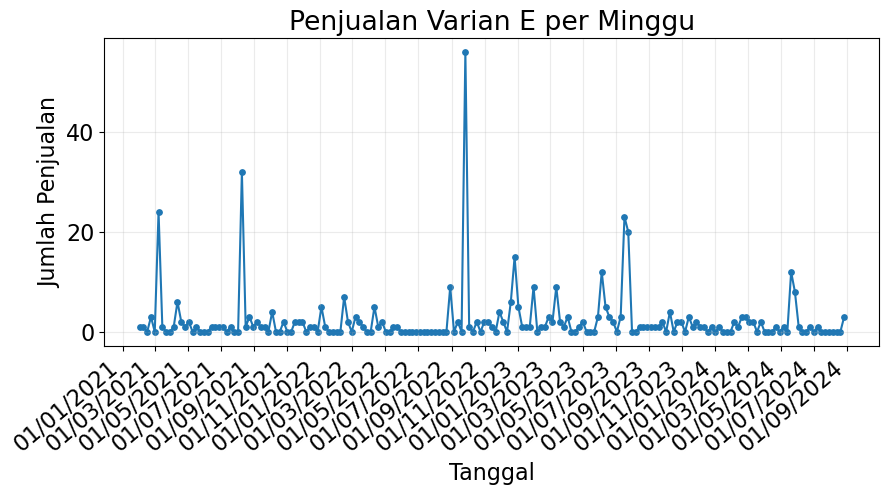

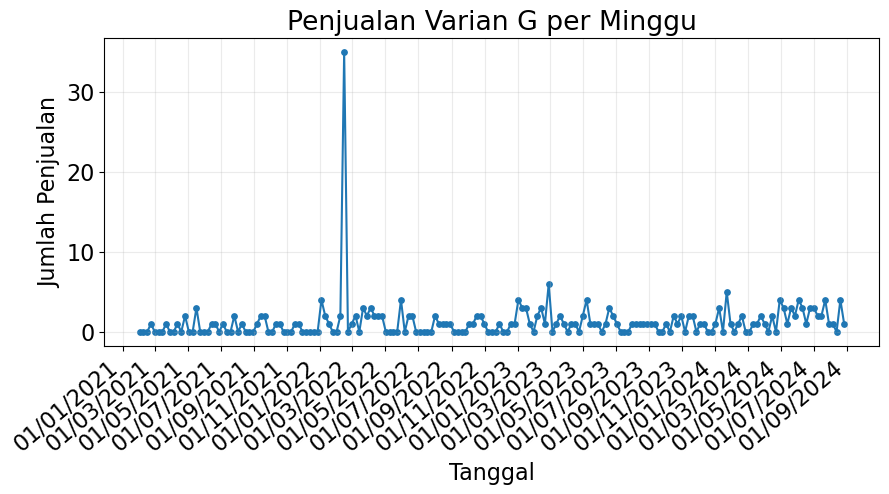

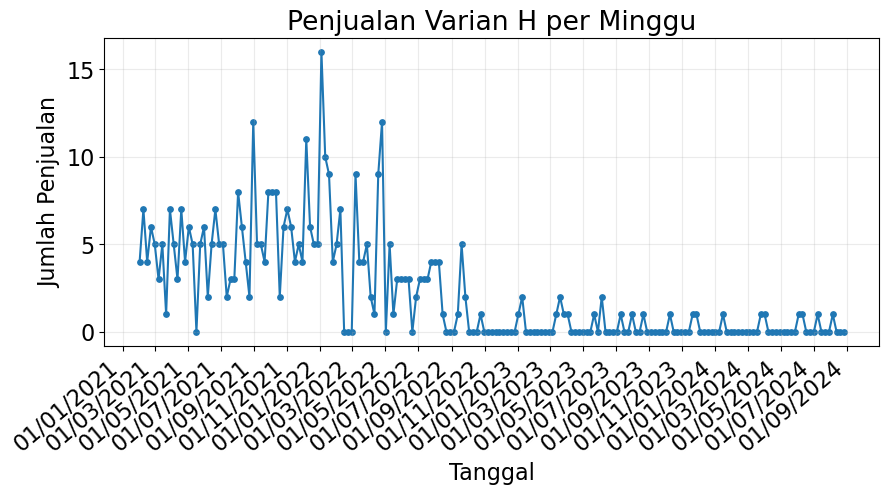

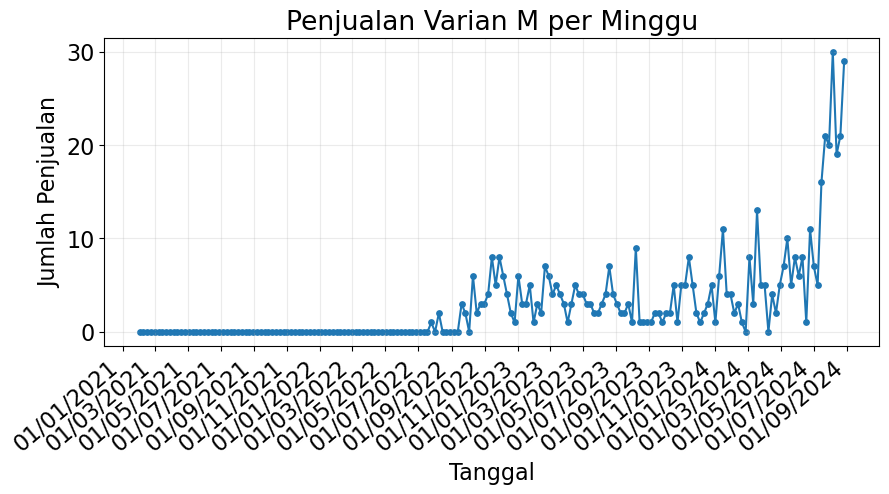

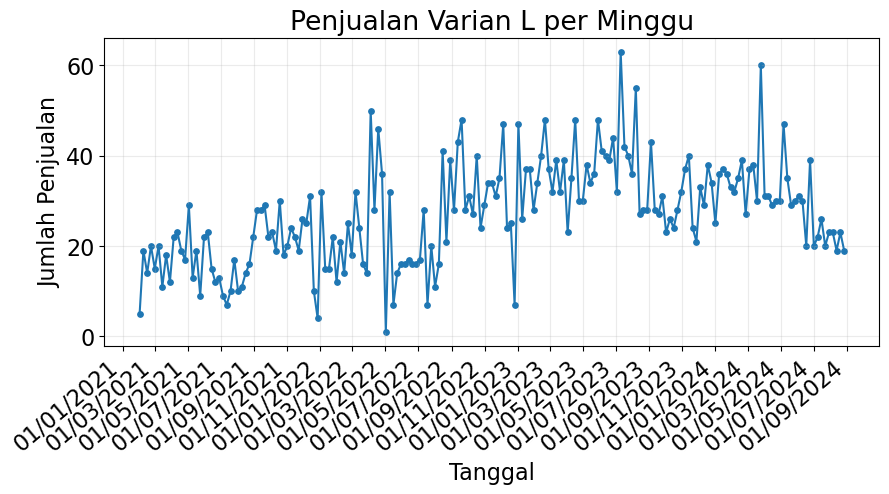

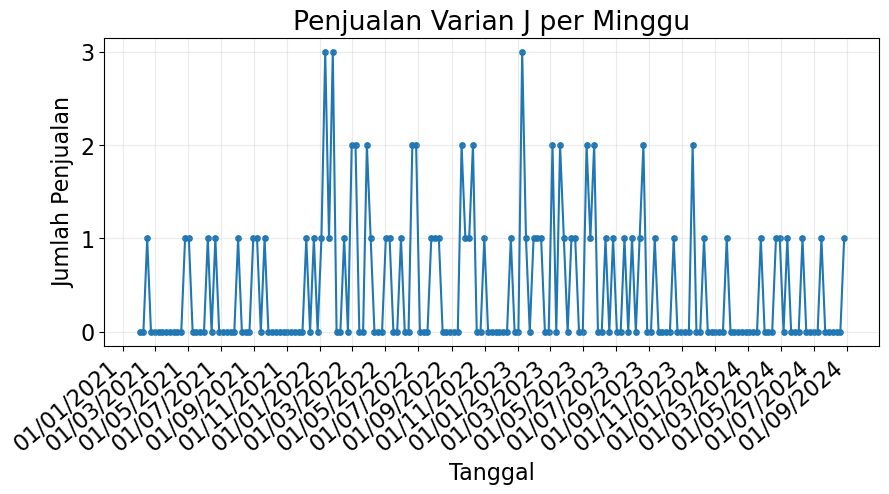

In [10]:
varian_mapping = {0: "E", 1: "G", 2: "H", 3: "J", 4: "L", 5: "M"}

df_weekly_varian = df_cdb_week[["Year", "Week", 0, 1, 2, 3, 4, 5]].copy()
df_weekly_varian = df_weekly_varian.melt(id_vars=["Year", "Week"], var_name="Varian Label", value_name="Sales")

df_weekly_varian["Varian"] = df_weekly_varian["Varian Label"].map(varian_mapping)
df_weekly_varian = df_weekly_varian.drop(columns=["Varian Label"])

df_weekly_varian["Date"] = df_weekly_varian.apply(lambda row: pd.Timestamp.fromisocalendar(row["Year"], row["Week"], 1), axis=1)
df_weekly_varian = df_weekly_varian.sort_values(by=["Date"])

for varian in df_weekly_varian["Varian"].unique():
    df_varian = df_weekly_varian[df_weekly_varian["Varian"] == varian]
    plot_time_series(df_varian["Date"], df_varian["Sales"], 
                     xlabel="Tanggal", ylabel="Jumlah Penjualan", 
                     title=f"Penjualan Varian {varian} per Minggu")


## EDA

#### Test korelasi
fitur numerik :
- umur 

fitur kategorikal :
1. nominal, tidak memiliki urutan atau ranking
2. ordinal, memiliki urutan atau ranking
- kelurahan (nominal)
- kecamatan (nominal)
- gender (nominal)
- pekerjaan (nominal)
- pengeluaran (ordinal)
- pendidikan (ordinal)
- tipe pembeli (nominal)

korelasi yang digunakan terhadap fitur initial varian (kategorikal)
- umur → Spearman
- kelurahan → Chi-Square
- kecamatan → Chi-Square
- gender → Chi-Square
- pekerjaan → Chi-Square
- pengeluaran → Spearman
- pendidikan → Spearman
- tipe pembeli → Chi-Square

In [13]:
spearman_features = ["Umur", "Pengeluaran", "Pendidikan"]

for feature in spearman_features:
    spearman_corr, p_value = stats.spearmanr(df_cdb_week[feature], df_cdb_week["Total Sales"])
    
    interpretation = "Hubungan lemah atau tidak signifikan"
    if 1 >= spearman_corr >= 0.5:
        interpretation = "Hubungan positif"
    elif -1 <= spearman_corr <= -0.5:
        interpretation = "Hubungan negatif"

    signifikan = "signifikan" if p_value < 0.05 else "tidak signifikan"

    print(f"{feature}:")
    print(f"Spearman (rs): {spearman_corr:.4f}")
    print(f"p-value: {p_value:.4f} ({signifikan})")
    print(f"{interpretation} antara {feature} dan Total Sales\n")

Umur:
Spearman (rs): -0.1101
p-value: 0.1336 (tidak signifikan)
Hubungan lemah atau tidak signifikan antara Umur dan Total Sales

Pengeluaran:
Spearman (rs): -0.0458
p-value: 0.5333 (tidak signifikan)
Hubungan lemah atau tidak signifikan antara Pengeluaran dan Total Sales

Pendidikan:
Spearman (rs): 0.4013
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pendidikan dan Total Sales



In [14]:
chi_square_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Tipe Pembeli"]

def chi_square_test(feature, df):
    contingency_table = pd.crosstab(df[feature], df["Total Sales"])
    
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    signifikan = 0.05
    critical_value = stats.chi2.ppf(q=1-signifikan, df=dof)

    print(f"\nFeature: {feature}")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Critical Value (alpha={signifikan}): {critical_value:.4f}")
    print(f"P-Value: {p:.4f}")

    if p < signifikan:
        print("Signifikan, ada hubungan antara variabel dengan Total Sales")
    else:
        print("Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales")

for feature in chi_square_features:
    chi_square_test(feature, df_cdb_week)



Feature: Kelurahan
Chi-Square Statistic: 9665.5625
Degrees of Freedom: 9620
Critical Value (alpha=0.05): 9849.2863
P-Value: 0.3697
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Kecamatan
Chi-Square Statistic: 9133.3917
Degrees of Freedom: 9048
Critical Value (alpha=0.05): 9270.3992
P-Value: 0.2618
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Gender
Chi-Square Statistic: 7622.0977
Degrees of Freedom: 6500
Critical Value (alpha=0.05): 6688.6723
P-Value: 0.0000
Signifikan, ada hubungan antara variabel dengan Total Sales

Feature: Pekerjaan
Chi-Square Statistic: 9403.2431
Degrees of Freedom: 9360
Critical Value (alpha=0.05): 9586.1819
P-Value: 0.3743
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Tipe Pembeli
Chi-Square Statistic: 3987.2803
Degrees of Freedom: 3120
Critical Value (alpha=0.05): 3251.0601
P-Value: 0.0000
Signifikan, ada hubungan antara variabel dengan Total Sales


Berdasarkan hasil test korelasi, variabel yang relevan untuk digunakan dalam model peramalan yaitu `Pendidikan`, `Gender`, `Tipe Pembeli`

1. Spearman

In [15]:
spearman_pengeluaran, p_value_pengeluaran = stats.spearmanr(df_cdb_enc["Umur"], df_cdb_enc["initial Varian Plus"])
spearman_pengeluaran, p_value_pengeluaran = stats.spearmanr(df_cdb_enc["Pengeluaran"], df_cdb_enc["initial Varian Plus"])
spearman_pendidikan, p_value_pendidikan = stats.spearmanr(df_cdb_enc["Pendidikan"], df_cdb_enc["initial Varian Plus"])

def interpret_spearman(corr, p_value, feature_name):
    if 1 >= corr >= 0.5:
        interpretation = "Hubungan positif"
    elif -1 <= corr <= -0.5:
        interpretation = "Hubungan negatif"
    elif 0.5 > corr > -0.5:
        interpretation = "Hubungan lemah atau tidak signifikan"
    else:
        interpretation = "Tidak ada hubungan monotonic yang signifikan"

    signifikan = "signifikan" if p_value < 0.05 else "tidak signifikan"

    print(f"{feature_name}:")
    print(f"Spearman (rs): {corr:.4f}")
    print(f"p-value: {p_value:.4f} ({signifikan})")
    print(f"{interpretation} antara {feature_name} dan Initial Varian Plus\n")

interpret_spearman(spearman_pengeluaran, p_value_pengeluaran, "Umur")
interpret_spearman(spearman_pengeluaran, p_value_pengeluaran, "Pengeluaran")
interpret_spearman(spearman_pendidikan, p_value_pendidikan, "Pendidikan")


Umur:
Spearman (rs): -0.1666
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Umur dan Initial Varian Plus

Pengeluaran:
Spearman (rs): -0.1666
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pengeluaran dan Initial Varian Plus

Pendidikan:
Spearman (rs): -0.1773
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pendidikan dan Initial Varian Plus



maka pengeluaran dan pendidikan memiliki sedikit hubungan, tetapi tidak cukup kuat untuk dianggap pola yang konsisten (tidak signifikan)

2. Chi-Square

In [16]:
chi_square_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Tipe Pembeli"]

def chi_square_test(feature, df_cdb_enc):
    contingency_table = pd.crosstab(df_cdb_enc[feature], df_cdb_enc["initial Varian Plus"])
    
    # uji chi-square
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\nFeature: {feature}")
    # print("Contingency Table:\n", contingency_table)
    # print("Observed Values:\n", contingency_table.values)
    # print("Expected Values:\n", expected)
    
    # critical value pada alpha 0.05
    signifikan = 0.05
    critical_value = stats.chi2.ppf(q=1-signifikan, df=dof)

    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Critical Value (alpha={signifikan}): {critical_value:.4f}")
    print(f"P-Value: {p:.4f}")

    if chi2>=critical_value:
        print("Reject H0, kedua variabel memiliki hubungan")
    else:
        print("Retain H0, kedua variabel tidak memiliki hubungan")
    
    if p_value<=signifikan:
        print("Signifikan, ada hubungan antar variabel")
    else:
        print("Tidak signifikan, tidak ada hubungan antar variabel")

for feature in chi_square_features:
    chi_square_test(feature, df_cdb_enc)


Feature: Kelurahan
Chi-Square Statistic: 3440.6783
Degrees of Freedom: 1195
Critical Value (alpha=0.05): 1276.5339
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Kecamatan
Chi-Square Statistic: 1783.7131
Degrees of Freedom: 275
Critical Value (alpha=0.05): 314.6784
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Gender
Chi-Square Statistic: 2828.0356
Degrees of Freedom: 10
Critical Value (alpha=0.05): 18.3070
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Pekerjaan
Chi-Square Statistic: 2871.8442
Degrees of Freedom: 115
Critical Value (alpha=0.05): 141.0297
P-Value: 0.0000
Reject H0, kedua variabel memiliki hubungan
Signifikan, ada hubungan antar variabel

Feature: Tipe Pembeli
Chi-Square Statistic: 2674.3529
Degrees of Freedom: 5
Critical Value (alpha=0.05): 11.0705
P-Value: 0.0000
Reject H0, kedua 

alpha (α) adalah batas yang ditentukan sebelum uji statistik, sedangkan p-value adalah hasil dari uji statistik itu sendiri.

In [17]:
# contingency_table=pd.crosstab(df_cdb_enc["Kelurahan"],df_cdb_enc["initial Varian Plus"])
# print("contingency_table :-\n",contingency_table)

In [18]:
adf_results = []

for varian in ["E", "G", "H", "J", "L", "M"]:
    df_varian = df_weekly_varian[df_weekly_varian["Varian"] == varian]
    
    if not df_varian["Sales"].isnull().all():
        result = adfuller(df_varian["Sales"].dropna())
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"

        adf_results.append([
            varian, result[0], p_value, 
            result[4]["1%"], result[4]["5%"], result[4]["10%"], 
            is_stationary
        ])

df_adf = pd.DataFrame(adf_results, columns=["Varian", "ADF Statistic", "p-value", 
                                            "1%", "5%", "10%", "Result"])
df_adf

,Varian,ADF Statistic,p-value,1%,5%,10%,Result
0,E,-12.904754,4.175600e-24,-3.466005,-2.877208,-2.575122,stasioner
1,G,-13.269614,8.087010e-25,-3.466005,-2.877208,-2.575122,stasioner
2,H,-0.954460,7.695096e-01,-3.468726,-2.878396,-2.575756,tidak stasioner
3,J,-4.709089,8.090598e-05,-3.466800,-2.877555,-2.575308,stasioner
4,L,-2.624652,8.800855e-02,-3.466800,-2.877555,-2.575308,tidak stasioner
5,M,2.260152,9.989285e-01,-3.468062,-2.878106,-2.575602,tidak stasioner


First Diff

In [19]:
df_weekly_varian_diff = df_weekly_varian.copy()

for varian in ["H", "L", "M"]:
    df_weekly_varian_diff.loc[df_weekly_varian_diff["Varian"] == varian, "Sales"] = (
        df_weekly_varian_diff.loc[df_weekly_varian_diff["Varian"] == varian, "Sales"].diff()
    )

adf_results_diff = []

for varian in ["H", "L", "M"]:
    df_varian_diff = df_weekly_varian_diff[df_weekly_varian_diff["Varian"] == varian]
    
    if not df_varian_diff["Sales"].isnull().all():
        result = adfuller(df_varian_diff["Sales"].dropna())
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"

        adf_results_diff.append([
            varian, result[0], p_value,
            result[4]["1%"], result[4]["5%"], result[4]["10%"],
            is_stationary
        ])

df_adf_diff = pd.DataFrame(adf_results_diff, columns=["Varian", "ADF Statistic", "p-value",
                                                      "1%", "5%", "10%", "Result first_diff"])

df_adf_diff


,Varian,ADF Statistic,p-value,1%,5%,10%,Result first_diff
0,H,-4.694218,8.628280e-05,-3.469413,-2.878696,-2.575917,stasioner
1,L,-10.777786,2.296086e-19,-3.466800,-2.877555,-2.575308,stasioner
2,M,1.136012,9.955125e-01,-3.468952,-2.878495,-2.575809,tidak stasioner


Second Differencing for varian M

In [20]:
df_weekly_varian_diff.loc[df_weekly_varian_diff["Varian"] == "M", "Sales"] = (
    df_weekly_varian_diff.loc[df_weekly_varian_diff["Varian"] == "M", "Sales"].diff()
)

df_varian_M_diff = df_weekly_varian_diff[df_weekly_varian_diff["Varian"] == "M"]

if not df_varian_M_diff["Sales"].isnull().all():
    result_M = adfuller(df_varian_M_diff["Sales"].dropna())
    p_value_M = result_M[1]
    is_stationary_M = "stasioner" if p_value_M < 0.05 else "tidak stasioner"

    adf_result_M = {
        "Varian": "M",
        "ADF Statistic": result_M[0],
        "p-value": p_value_M,
        "Critical Value 1%": result_M[4]["1%"],
        "Critical Value 5%": result_M[4]["5%"],
        "Critical Value 10%": result_M[4]["10%"],
        "Result second_diff": is_stationary_M
    }

    df_adf_sec_diff = pd.DataFrame([adf_result_M])

df_adf_sec_diff

,Varian,ADF Statistic,p-value,Critical Value 1%,Critical Value 5%,Critical Value 10%,Result second_diff
0,M,-7.09129,4.403443e-10,-3.468952,-2.878495,-2.575809,stasioner


ACF

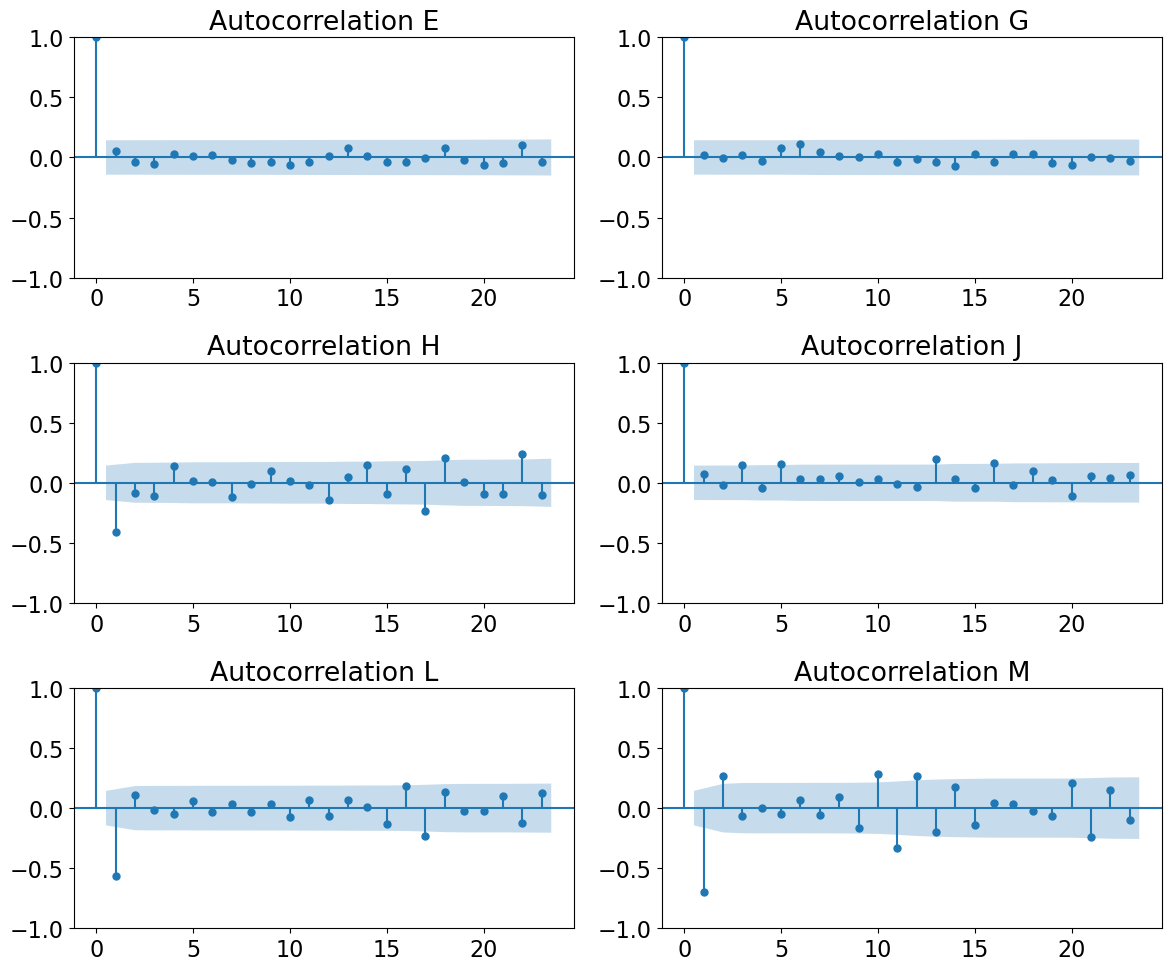

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

varian_list = ["E", "G", "H", "J", "L", "M"]
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    df_varian = df_weekly_varian_diff[df_weekly_varian_diff["Varian"] == varian]
    
    if not df_varian["Sales"].isnull().all():
        plot_acf(df_varian["Sales"].dropna(), ax=axes[i], title=f"Autocorrelation {varian}")

plt.tight_layout()
plt.show()


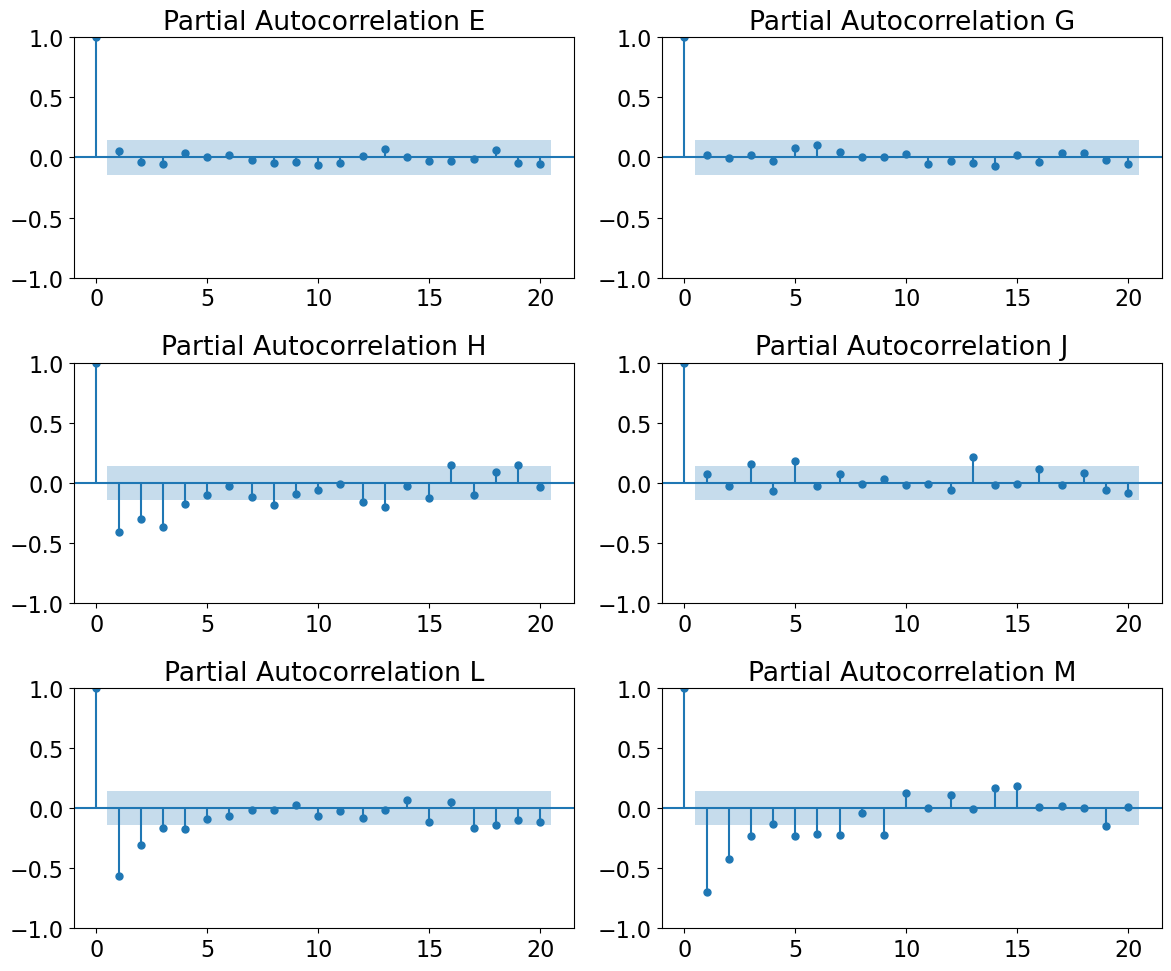

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    df_varian = df_weekly_varian_diff[df_weekly_varian_diff["Varian"] == varian]
    
    if not df_varian["Sales"].isnull().all():
        plot_pacf(df_varian["Sales"].dropna(), lags=20, ax=axes[i])
        axes[i].set_title(f"Partial Autocorrelation {varian}")

plt.tight_layout()
plt.show()

- `E`, `G`, dan `J` tidak ada lag yg signifikan 
- `H` langsung turun pada lag 1 tp tdk terlalu signifikan
- `L` dan `M` langsung drop dari lag 1

### Plot kumulatif

In [23]:
df_cdb_enc["Tgl. Mohon"] = pd.to_datetime(df_cdb_enc["Tgl. Mohon"])

df_cdb_enc["Year"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().year
df_cdb_enc["Week"] = df_cdb_enc["Tgl. Mohon"].dt.isocalendar().week

df_cdb_week_cum = df_cdb_enc.groupby(["Year", "Week"]).agg({
    "Nama": "count",
    "Kelurahan": "mean",
    "Kecamatan": "mean",
    "Gender": "mean",
    "Pekerjaan": "mean",  
    "Pengeluaran": "mean",
    "Pendidikan": "mean",
    "Tipe Pembeli": "mean",
    "Umur": "mean"
}).reset_index()

df_cdb_week.rename(columns={"Nama": "Total Sales"}, inplace=True)

varian_counts = df_cdb_enc.groupby(["Year", "Week"])["initial Varian Plus"].value_counts().unstack(fill_value=0).reset_index()

df_cdb_week_cum = df_cdb_week_cum.merge(varian_counts, on=["Year", "Week"], how="left")

varian_columns = df_cdb_enc["initial Varian Plus"].unique().tolist()
varian_columns = sorted(varian_columns)

date_range = pd.date_range(start="2021-02-01", end="2024-08-31", freq="W-MON")
df_all_weeks_cum = pd.DataFrame({"Date": date_range})
df_all_weeks_cum["Year"] = df_all_weeks_cum["Date"].dt.isocalendar().year
df_all_weeks_cum["Week"] = df_all_weeks_cum["Date"].dt.isocalendar().week
df_all_weeks_cum = df_all_weeks_cum.drop(columns=["Date"])

df_cdb_week_cum = df_all_weeks_cum.merge(df_cdb_week_cum, on=["Year", "Week"], how="left").fillna(0)

df_cdb_week_cum[varian_columns] = df_cdb_week_cum[varian_columns].cumsum()
df_cdb_week.to_csv("CDB_week_cum.csv", index=False)
df_cdb_week_cum

,Year,Week,Nama,Kelurahan,Kecamatan,Gender,Pekerjaan,Pengeluaran,Pendidikan,Tipe Pembeli,Umur,0,1,2,3,4,5
0,2021,5,10,120.000000,4.200000,0.400000,9.600000,3.200000,3.200000,0.000000,35.500000,1,0,4,0,5,0
1,2021,6,27,112.592593,6.888889,0.555556,10.074074,2.962963,3.481481,0.000000,42.518519,2,0,11,0,24,0
2,2021,7,19,121.315789,11.105263,0.421053,13.842105,2.789474,3.157895,0.000000,43.578947,2,0,15,1,38,0
3,2021,8,30,101.400000,6.366667,0.500000,10.966667,3.533333,3.700000,0.066667,40.600000,5,1,21,1,58,0
4,2021,9,20,113.050000,9.550000,0.300000,11.900000,3.550000,3.800000,0.000000,41.900000,5,1,26,1,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024,31,44,113.181818,4.636364,0.500000,7.431818,3.272727,3.840909,0.022727,38.363636,415,228,417,83,4973,434
183,2024,32,55,106.836364,5.690909,0.454545,8.236364,3.563636,3.836364,0.000000,38.836364,415,229,418,83,4996,464
184,2024,33,38,99.763158,4.710526,0.526316,7.552632,3.157895,3.552632,0.000000,36.710526,415,229,418,83,5015,483
185,2024,34,48,95.166667,5.562500,0.500000,8.270833,3.145833,3.770833,0.000000,37.187500,415,233,418,83,5038,504


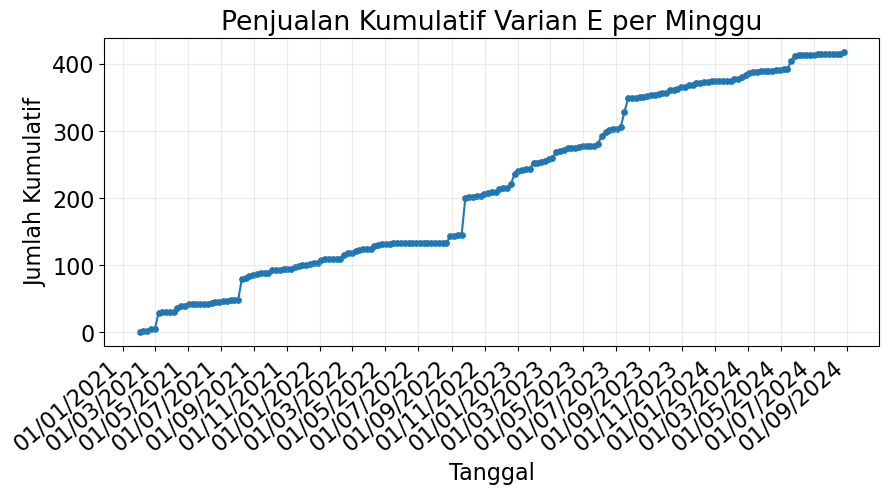

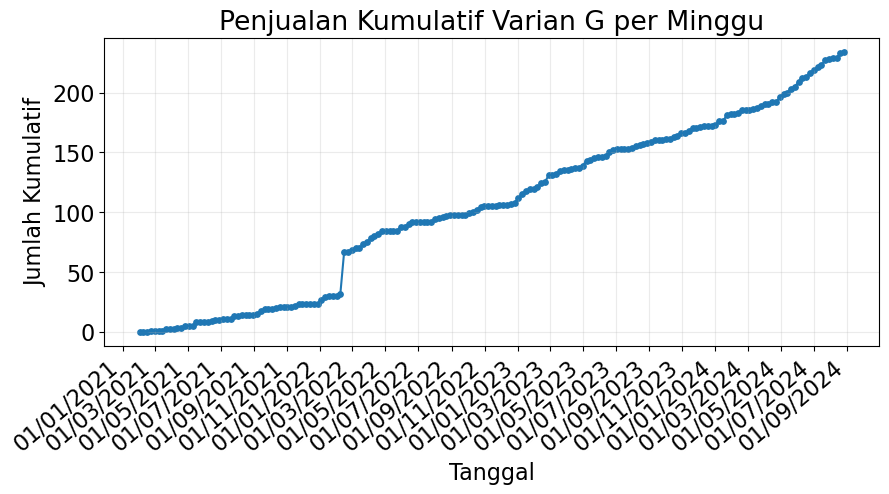

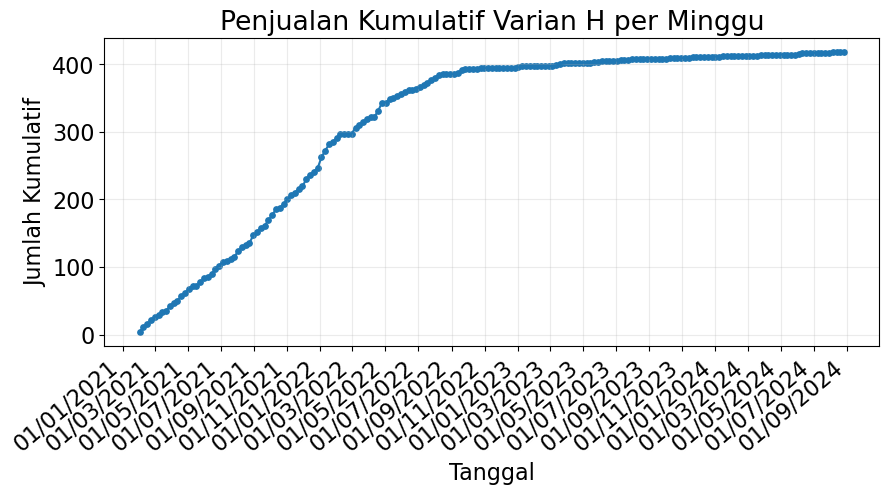

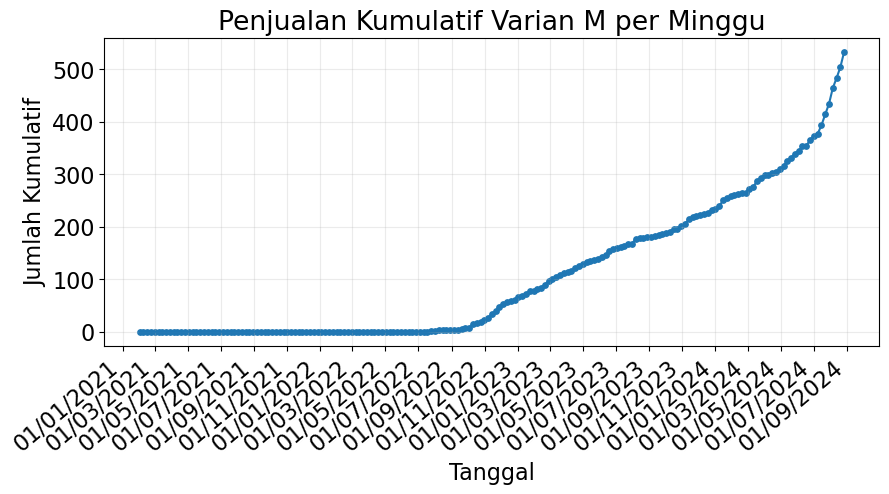

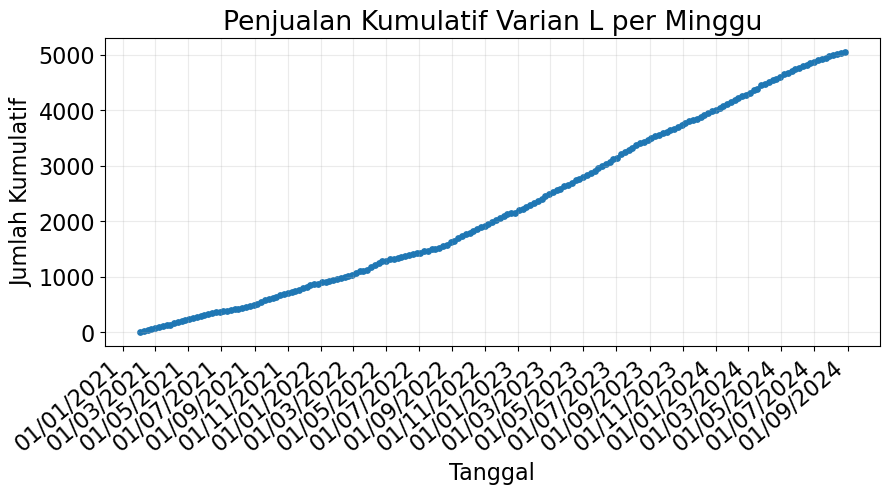

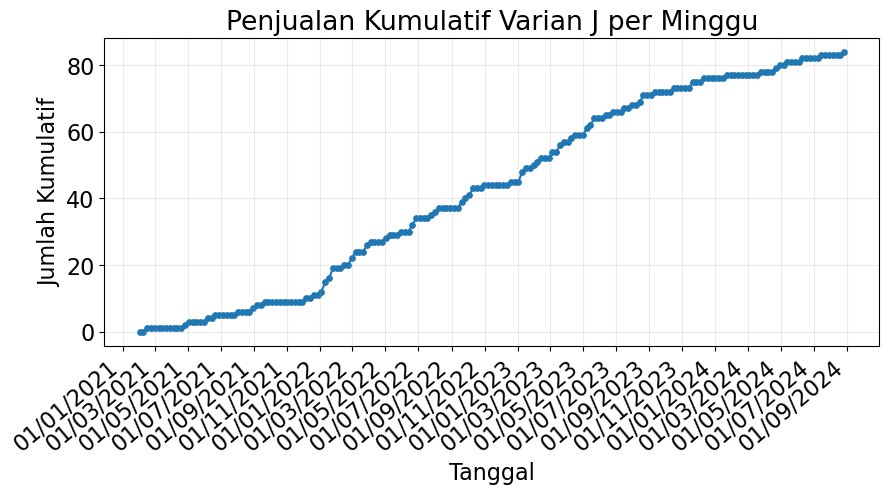

In [24]:
varian_mapping_cum = {0: "E", 1: "G", 2: "H", 3: "J", 4: "L", 5: "M"}

df_weekly_varian_cum = df_cdb_week_cum[["Year", "Week", 0, 1, 2, 3, 4, 5]].copy()
df_weekly_varian_cum = df_weekly_varian_cum.melt(id_vars=["Year", "Week"], var_name="Varian Label", value_name="Sales")

df_weekly_varian_cum["Varian"] = df_weekly_varian_cum["Varian Label"].map(varian_mapping_cum)
df_weekly_varian_cum = df_weekly_varian_cum.drop(columns=["Varian Label"])

df_weekly_varian_cum["Date"] = df_weekly_varian_cum.apply(lambda row: pd.Timestamp.fromisocalendar(row["Year"], row["Week"], 1), axis=1)
df_weekly_varian_cum = df_weekly_varian_cum.sort_values(by=["Date"])

for varian in df_weekly_varian_cum["Varian"].unique():
    df_varian_cum = df_weekly_varian_cum[df_weekly_varian_cum["Varian"] == varian]
    plot_time_series(df_varian_cum["Date"], df_varian_cum["Sales"], 
                     xlabel="Tanggal", ylabel="Jumlah Kumulatif", 
                     title=f"Penjualan Kumulatif Varian {varian} per Minggu")


In [25]:
df_weekly_varian_cum

,Year,Week,Sales,Varian,Date
0,2021,5,1,E,2021-02-01
187,2021,5,0,G,2021-02-01
374,2021,5,4,H,2021-02-01
935,2021,5,0,M,2021-02-01
748,2021,5,5,L,2021-02-01
...,...,...,...,...,...
747,2024,35,84,J,2024-08-26
373,2024,35,234,G,2024-08-26
186,2024,35,418,E,2024-08-26
934,2024,35,5057,L,2024-08-26


## EDA Cum

#### Test korelasi
fitur numerik :
- umur 

fitur kategorikal :
1. nominal, tidak memiliki urutan atau ranking
2. ordinal, memiliki urutan atau ranking
- kelurahan (nominal)
- kecamatan (nominal)
- gender (nominal)
- pekerjaan (nominal)
- pengeluaran (ordinal)
- pendidikan (ordinal)
- tipe pembeli (nominal)

korelasi yang digunakan terhadap fitur initial varian (kategorikal)
- umur → Spearman
- kelurahan → Chi-Square
- kecamatan → Chi-Square
- gender → Chi-Square
- pekerjaan → Chi-Square
- pengeluaran → Spearman
- pendidikan → Spearman
- tipe pembeli → Chi-Square

1. Spearman

In [26]:
spearman_features = ["Umur", "Pengeluaran", "Pendidikan"]

for feature in spearman_features:
    spearman_corr, p_value = stats.spearmanr(df_cdb_week_cum[feature], df_cdb_week_cum["Nama"])
    
    interpretation = "Hubungan lemah atau tidak signifikan"
    if 1 >= spearman_corr >= 0.5:
        interpretation = "Hubungan positif"
    elif -1 <= spearman_corr <= -0.5:
        interpretation = "Hubungan negatif"

    signifikan = "signifikan" if p_value < 0.05 else "tidak signifikan"

    print(f"{feature}:")
    print(f"Spearman (rs): {spearman_corr:.4f}")
    print(f"p-value: {p_value:.4f} ({signifikan})")
    print(f"{interpretation} antara {feature} dan Total Sales\n")

Umur:
Spearman (rs): -0.1101
p-value: 0.1336 (tidak signifikan)
Hubungan lemah atau tidak signifikan antara Umur dan Total Sales

Pengeluaran:
Spearman (rs): -0.0458
p-value: 0.5333 (tidak signifikan)
Hubungan lemah atau tidak signifikan antara Pengeluaran dan Total Sales

Pendidikan:
Spearman (rs): 0.4013
p-value: 0.0000 (signifikan)
Hubungan lemah atau tidak signifikan antara Pendidikan dan Total Sales



In [27]:
chi_square_features = ["Kelurahan", "Kecamatan", "Gender", "Pekerjaan", "Tipe Pembeli"]

def chi_square_test(feature, df):
    contingency_table = pd.crosstab(df[feature], df["Nama"])
    
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    signifikan = 0.05
    critical_value = stats.chi2.ppf(q=1-signifikan, df=dof)

    print(f"\nFeature: {feature}")
    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Critical Value (alpha={signifikan}): {critical_value:.4f}")
    print(f"P-Value: {p:.4f}")

    if p < signifikan:
        print("Signifikan, ada hubungan antara variabel dengan Total Sales")
    else:
        print("Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales")

for feature in chi_square_features:
    chi_square_test(feature, df_cdb_week_cum)



Feature: Kelurahan
Chi-Square Statistic: 9665.5625
Degrees of Freedom: 9620
Critical Value (alpha=0.05): 9849.2863
P-Value: 0.3697
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Kecamatan
Chi-Square Statistic: 9133.3917
Degrees of Freedom: 9048
Critical Value (alpha=0.05): 9270.3992
P-Value: 0.2618
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Gender
Chi-Square Statistic: 7622.0977
Degrees of Freedom: 6500
Critical Value (alpha=0.05): 6688.6723
P-Value: 0.0000
Signifikan, ada hubungan antara variabel dengan Total Sales

Feature: Pekerjaan
Chi-Square Statistic: 9403.2431
Degrees of Freedom: 9360
Critical Value (alpha=0.05): 9586.1819
P-Value: 0.3743
Tidak signifikan, tidak ada hubungan antara variabel dengan Total Sales

Feature: Tipe Pembeli
Chi-Square Statistic: 3987.2803
Degrees of Freedom: 3120
Critical Value (alpha=0.05): 3251.0601
P-Value: 0.0000
Signifikan, ada hubungan antara variabel dengan Total Sales


### Cek Stasioner

In [28]:
adf_results = []

for varian in ["E", "G", "H", "J", "L", "M"]:
    df_varian_cum = df_weekly_varian_cum[df_weekly_varian_cum["Varian"] == varian]
    
    if not df_varian_cum["Sales"].isnull().all():
        result = adfuller(df_varian_cum["Sales"].dropna())
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"

        adf_results.append([
            varian, result[0], p_value, 
            result[4]["1%"], result[4]["5%"], result[4]["10%"], 
            is_stationary
        ])

df_adf_cum = pd.DataFrame(adf_results, columns=["Varian", "ADF Statistic", "p-value", 
                                            "1%", "5%", "10%", "Result"])
df_adf_cum

,Varian,ADF Statistic,p-value,1%,5%,10%,Result
0,E,-0.645361,0.860399,-3.466005,-2.877208,-2.575122,tidak stasioner
1,G,0.802287,0.991673,-3.466005,-2.877208,-2.575122,tidak stasioner
2,H,-2.812013,0.056578,-3.468952,-2.878495,-2.575809,tidak stasioner
3,J,-0.708928,0.844424,-3.467005,-2.877644,-2.575355,tidak stasioner
4,L,1.866830,0.998473,-3.466598,-2.877467,-2.575260,tidak stasioner
5,M,1.525957,0.997618,-3.469181,-2.878595,-2.575863,tidak stasioner


First Diff

In [29]:
df_weekly_varian_cum_diff = df_weekly_varian.copy()

for varian in ["E", "G", "H", "J", "L", "M"]:
    df_weekly_varian_cum_diff.loc[df_weekly_varian_cum_diff["Varian"] == varian, "Sales"] = (
        df_weekly_varian_cum_diff.loc[df_weekly_varian_cum_diff["Varian"] == varian, "Sales"].diff()
    )

adf_results_cum_diff = []

for varian in ["E", "G", "H", "J", "L", "M"]:
    df_varian_cum_diff = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian]
    
    if not df_varian_cum_diff["Sales"].isnull().all():
        result = adfuller(df_varian_cum_diff["Sales"].dropna())
        p_value = result[1]
        is_stationary = "stasioner" if p_value < 0.05 else "tidak stasioner"

        adf_results_cum_diff.append([
            varian, result[0], p_value,
            result[4]["1%"], result[4]["5%"], result[4]["10%"],
            is_stationary
        ])

df_adf_cum_diff = pd.DataFrame(adf_results_cum_diff, columns=["Varian", "ADF Statistic", "p-value",
                                                      "1%", "5%", "10%", "Result first_diff"])

df_adf_cum_diff


,Varian,ADF Statistic,p-value,1%,5%,10%,Result first_diff
0,E,-9.370096,7.417281e-16,-3.467211,-2.877735,-2.575403,stasioner
1,G,-9.955560,2.449584e-17,-3.467211,-2.877735,-2.575403,stasioner
2,H,-4.694218,8.628280e-05,-3.469413,-2.878696,-2.575917,stasioner
3,J,-6.979035,8.283658e-10,-3.468502,-2.878298,-2.575704,stasioner
4,L,-10.777786,2.296086e-19,-3.466800,-2.877555,-2.575308,stasioner
5,M,1.136012,9.955125e-01,-3.468952,-2.878495,-2.575809,tidak stasioner


Sec Diff

In [30]:
df_weekly_varian_cum_diff.loc[df_weekly_varian_cum_diff["Varian"] == "M", "Sales"] = (
    df_weekly_varian_cum_diff.loc[df_weekly_varian_cum_diff["Varian"] == "M", "Sales"].diff()
)

df_varian_M_cum_diff = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == "M"]

if not df_varian_M_cum_diff["Sales"].isnull().all():
    result_M = adfuller(df_varian_M_cum_diff["Sales"].dropna())
    p_value_M = result_M[1]
    is_stationary_M = "stasioner" if p_value_M < 0.05 else "tidak stasioner"

    adf_result_M_cum = {
        "Varian": "M",
        "ADF Statistic": result_M[0],
        "p-value": p_value_M,
        "Critical Value 1%": result_M[4]["1%"],
        "Critical Value 5%": result_M[4]["5%"],
        "Critical Value 10%": result_M[4]["10%"],
        "Result second_diff": is_stationary_M
    }

    df_adf_sec_cum_diff = pd.DataFrame([adf_result_M_cum])

df_adf_sec_cum_diff

,Varian,ADF Statistic,p-value,Critical Value 1%,Critical Value 5%,Critical Value 10%,Result second_diff
0,M,-7.09129,4.403443e-10,-3.468952,-2.878495,-2.575809,stasioner


ACF Cum

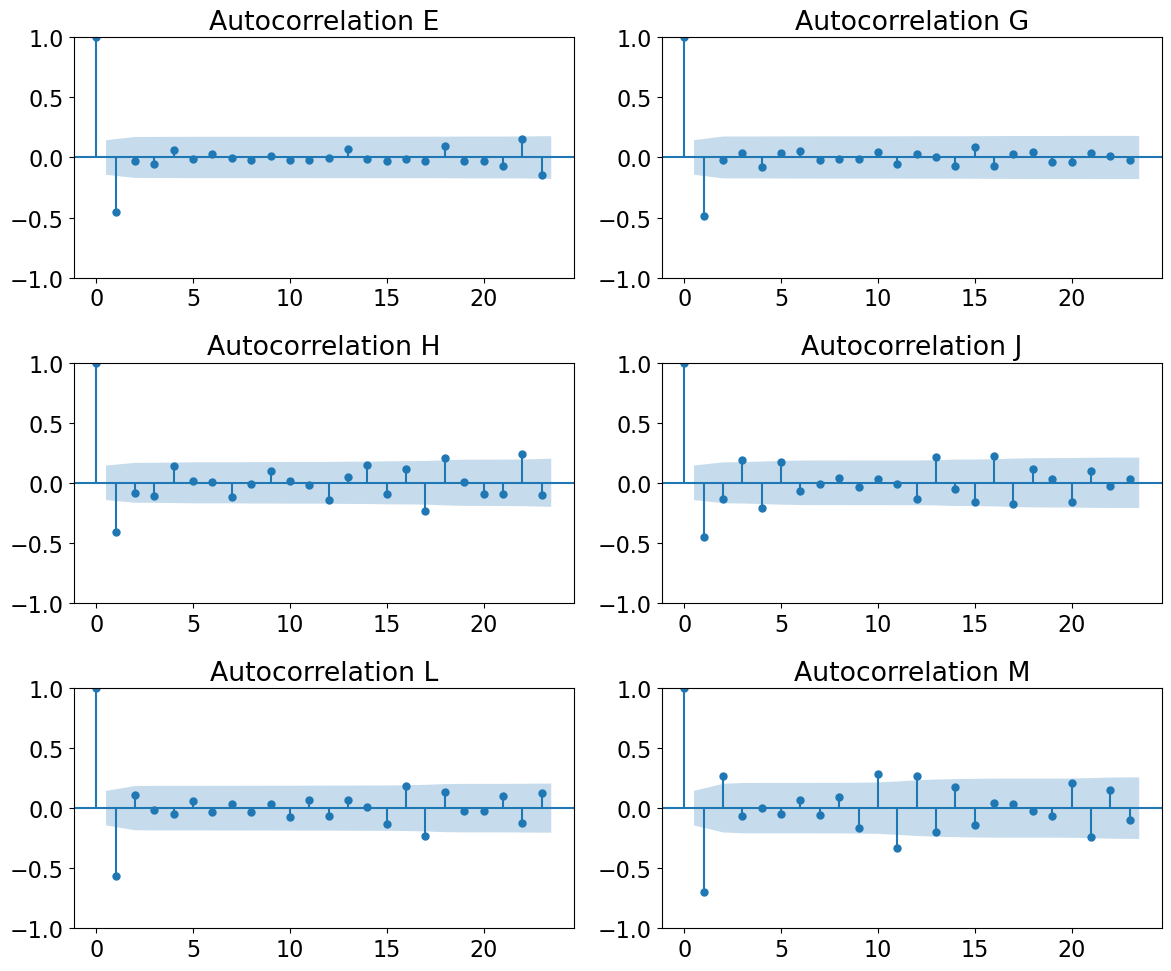

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

varian_list = ["E", "G", "H", "J", "L", "M"]
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    df_varian_cum = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian]
    
    if not df_varian_cum["Sales"].isnull().all():
        plot_acf(df_varian_cum["Sales"].dropna(), ax=axes[i], title=f"Autocorrelation {varian}")

plt.tight_layout()
plt.show()

PACF Cum

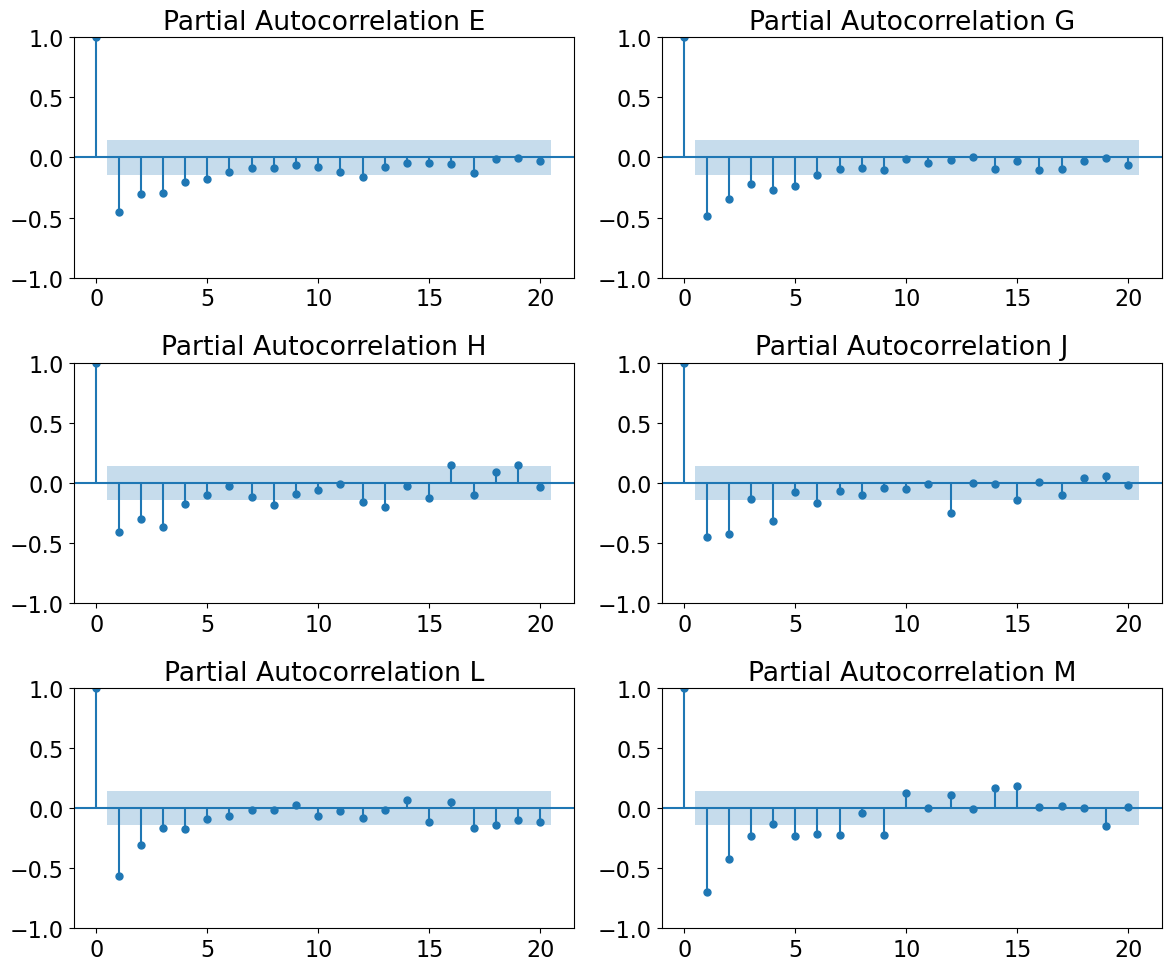

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, varian in enumerate(varian_list):
    df_varian_cum = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian]
    
    if not df_varian_cum["Sales"].isnull().all():
        plot_pacf(df_varian_cum["Sales"].dropna(), lags=20, ax=axes[i])
        axes[i].set_title(f"Partial Autocorrelation {varian}")

plt.tight_layout()
plt.show()

ACF data kumulatif langsung turun pada lag 1 dan pada PACF signifikan pada lag 1 untuk varian `L` dan `M` pada lag 2

#### Data Splitting

In [33]:
df_weekly_varian_cum_diff["Sales"] = df_weekly_varian_cum_diff["Sales"].fillna(0)

train_data = {}
test_data = {}

for varian in df_weekly_varian_cum_diff["Varian"].unique():
    df_varian = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian]
    
    split_idx = int(0.8 * len(df_varian))
    train_data[varian] = df_varian.iloc[:split_idx].copy()
    test_data[varian] = df_varian.iloc[split_idx:].copy()

for varian in train_data.keys():
    print(f"Varian {varian}: Train = {len(train_data[varian])}, Test = {len(test_data[varian])}")

Varian E: Train = 149, Test = 38
Varian G: Train = 149, Test = 38
Varian H: Train = 149, Test = 38
Varian M: Train = 149, Test = 38
Varian L: Train = 149, Test = 38
Varian J: Train = 149, Test = 38


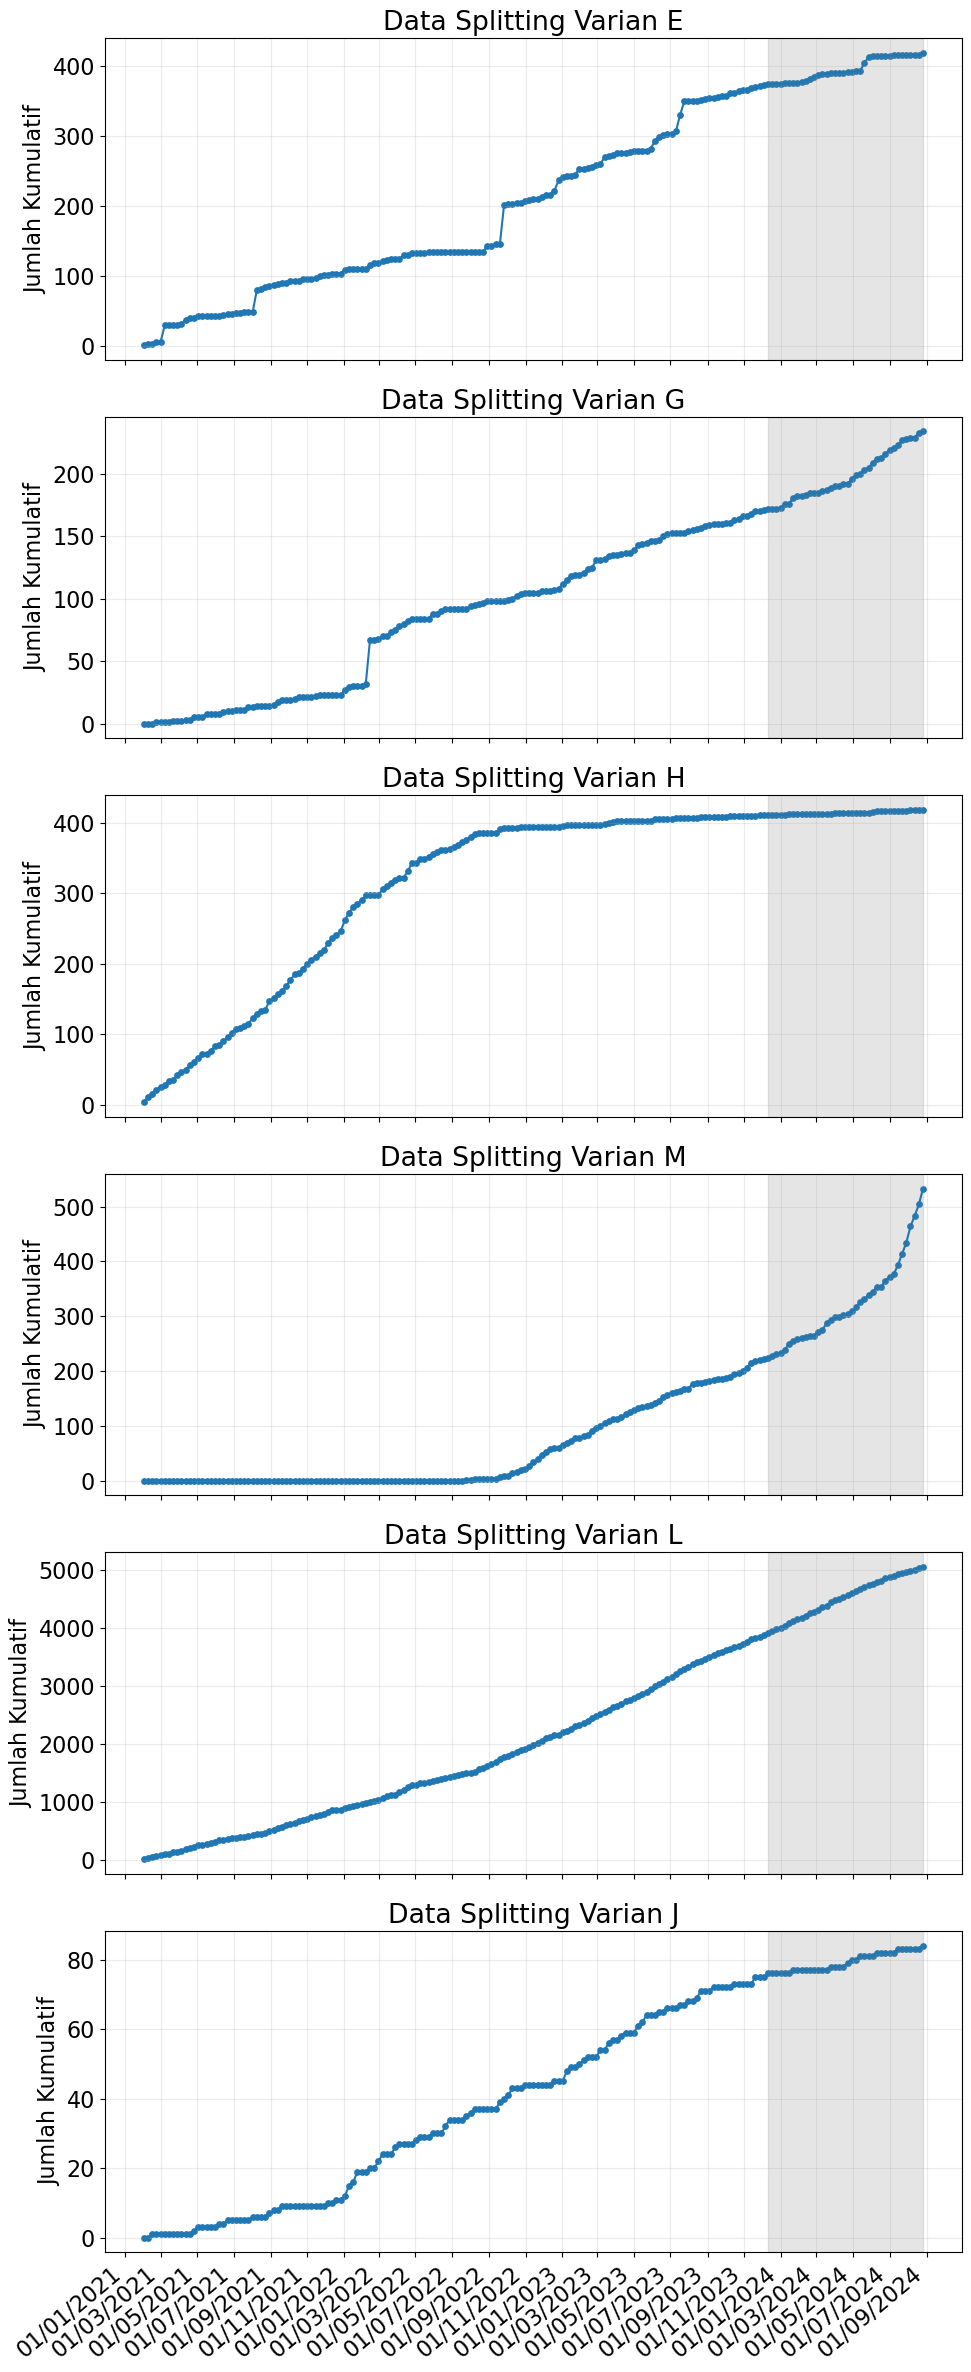

In [34]:
fig, axes = plt.subplots(nrows=len(train_data), figsize=(10, 4 * len(train_data)), sharex=True)

if len(train_data) == 1:
    axes = [axes]

for ax, (varian, df_train) in zip(axes, train_data.items()):
    df_test = test_data[varian]
    df_varian = df_weekly_varian_cum[df_weekly_varian_cum["Varian"] == varian]

    ax.plot(df_varian["Date"], df_varian["Sales"], color="tab:blue")
    ax.scatter(df_varian["Date"], df_varian["Sales"], marker="o", s=15, color="tab:blue")

    # area test data
    ax.axvspan(df_test["Date"].iloc[0], df_test["Date"].iloc[-1], 
                color="#808080", alpha=0.2)

    ax.set_ylabel("Jumlah Kumulatif")
    ax.set_title(f"Data Splitting Varian {varian}")
    ax.grid("on")

    formatter = mdates.DateFormatter("%d/%m/%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)

plt.setp(axes[-1].xaxis.get_majorticklabels(), 
        rotation=40, ha="right")

plt.tight_layout()
plt.show()


## Deploy Model

### ARMA

In [35]:
# p_space = range(0, 4, 1)
# q_space = range(0, 4, 1)

# order_list = list(itertls.product(p_space, q_space))
# order_list

In [36]:
# def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

#   result = []

#   for order in notebook.tqdm(order_list):
#     try:
#       model = SARIMAX(endog, order=(order[0], 0, order[1]), 
#                       simple_differencing=False).fit(disp=False)
#     except:
#       continue 

#     aic = model.aic
#     result.append([order, aic])

  
#   result_df = pd.DataFrame(result)
#   # print(result_df.columns)
#   result_df.columns = ["(p,q)", "AIC"]

#   # Sort in ascending order, lower AIC is better
#   result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

#   return result_df

In [37]:
# best_aic_results = {}

# for varian in ["E", "G", "H", "J", "L", "M"]:
#     if varian in df_weekly_varian_cum.columns:
#         print(f"\nOptimizing ARMA for Varian {varian}...")
#         result_df = optimize_ARMA(df_weekly_varian_cum[varian], order_list)
#         best_aic_results[varian] = result_df.iloc[0]
#         print(result_df)

### ARIMA

In [38]:
import warnings

def optimize_ARIMA(endog: pd.Series, order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:
    result = []
    # warnings.filterwarnings("error")   # handling warnings as error
    warnings.resetwarnings()     # to reset warnings
    
    for order in tqdm(order_list, desc="Optimizing ARIMA"):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), 
                            simple_differencing=False, 
                            enforce_invertibility=enforce_invertibility,
                            enforce_stationarity=enforce_stationarity).fit(disp=False)
            
            aic = model.aic
            result.append([order, aic])
        except:
            continue
    
    result_df = pd.DataFrame(result)
    # print(result_df.columns)
    result_df.columns = ["(p,q)", "AIC"]

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return result_df

In [39]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 2

print(f"integration order, d = {d}")
order_list = list(itertls.product(p_space, q_space))
order_list

integration order, d = 2


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [40]:
best_params = {}

for varian in df_weekly_varian_cum_diff["Varian"].unique():
    series = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian]["Sales"].astype(float)
    
    if series.isna().sum() > 0 or series.nunique() <= 1:
        continue
    
    best_model_df = optimize_ARIMA(series, order_list, d)
    best_model_df = best_model_df[~(best_model_df["(p,q)"] == (0, 0))]
    best_params[varian] = best_model_df.head(5)

best_params_df = pd.concat(best_params, names=["Varian"]).reset_index(level=0)
print(best_params_df)


Optimizing ARIMA:   0%|          | 0/16 [00:00<?, ?it/s]c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Optimizing ARIMA:  12%|█▎        | 2/16 [00:00<00:00, 14.96it/s]c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Optimizing ARIMA:  38%|███▊      | 6/16 [00:00<00:01,  7.21it/s]c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Optimizing ARIMA:  44%|████▍     | 7/16 [00:01<00:01,  6.14it/s]c:\ProgramData\miniconda3\Lib\site-packages\sta

  Varian   (p,q)          AIC
0      E  (0, 3)  1216.100466
1      E  (1, 3)  1217.420269
2      E  (3, 2)  1244.200518
3      E  (2, 2)  1258.082180
4      E  (3, 3)  1261.988331
0      G  (0, 3)   944.303529
1      G  (1, 3)   946.310162
2      G  (3, 2)   975.499313
3      G  (2, 2)   981.470586
4      G  (3, 3)   985.346958
0      H  (1, 3)   823.396089
1      H  (0, 3)   824.069122
2      H  (3, 2)   836.003094
3      H  (3, 3)   848.515946
4      H  (2, 2)   858.247567
0      M  (2, 3)   909.332882
1      M  (1, 3)   911.803013
2      M  (0, 3)   953.242816
3      M  (3, 2)   958.722264
4      M  (3, 3)   960.674907
0      L  (1, 3)  1364.080889
1      L  (0, 3)  1364.617145
2      L  (2, 3)  1369.299811
3      L  (3, 2)  1372.593605
4      L  (2, 2)  1375.068408
0      J  (0, 3)   426.505755
1      J  (2, 2)   456.145806
2      J  (3, 3)   458.346919
3      J  (2, 3)   483.341338
4      J  (1, 2)   489.553408


In [41]:
best_params_filtered = {}

for varian in best_params_df["Varian"].unique():
    varian_data = best_params_df[best_params_df["Varian"] == varian].copy()
    varian_data["(p,q)"] = varian_data["(p,q)"].apply(lambda x: eval(x) if isinstance(x, str) else x)
    
    # Filter agar (p, q) tidak 0
    varian_data_filtered = varian_data[varian_data["(p,q)"].apply(lambda x: x[0] != 0 and x[1] != 0)]
    
    if not varian_data_filtered.empty:
        best_params_filtered[varian] = varian_data_filtered.loc[varian_data_filtered["AIC"].idxmin(), ["(p,q)", "AIC"]]

if best_params_filtered:
    best_params_filtered_df = pd.DataFrame.from_dict(best_params_filtered, orient='index')
    best_params_filtered_df.reset_index(inplace=True)
    best_params_filtered_df.rename(columns={"index": "Varian"}, inplace=True)

print(best_params_filtered_df)


  Varian   (p,q)          AIC
0      E  (1, 3)  1217.420269
1      G  (1, 3)   946.310162
2      H  (1, 3)   823.396089
3      M  (2, 3)   909.332882
4      L  (1, 3)  1364.080889
5      J  (2, 2)   456.145806


In [42]:
models_arima_best = {}

for _, row in best_params_filtered_df.iterrows():
    varian = row["Varian"]
    best_p, best_q = row["(p,q)"]

    print(f"Training ARIMA({best_p},2,{best_q}) for Varian {varian}...")

    df_train = df_weekly_varian_cum_diff[
        df_weekly_varian_cum_diff["Varian"] == varian
    ]["Sales"].astype(float)

    if df_train.empty:
        continue

    model_arima_best = SARIMAX(
        df_train,
        order=(best_p, d, best_q),
        simple_differencing=False
    )
    
    model_arima_best_fit = model_arima_best.fit(disp=False)
    models_arima_best[varian] = model_arima_best_fit


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training ARIMA(1,2,3) for Varian E...
Training ARIMA(1,2,3) for Varian G...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training ARIMA(1,2,3) for Varian H...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training ARIMA(2,2,3) for Varian M...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training ARIMA(1,2,3) for Varian L...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Training ARIMA(2,2,2) for Varian J...


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting diagnostics for Varian E


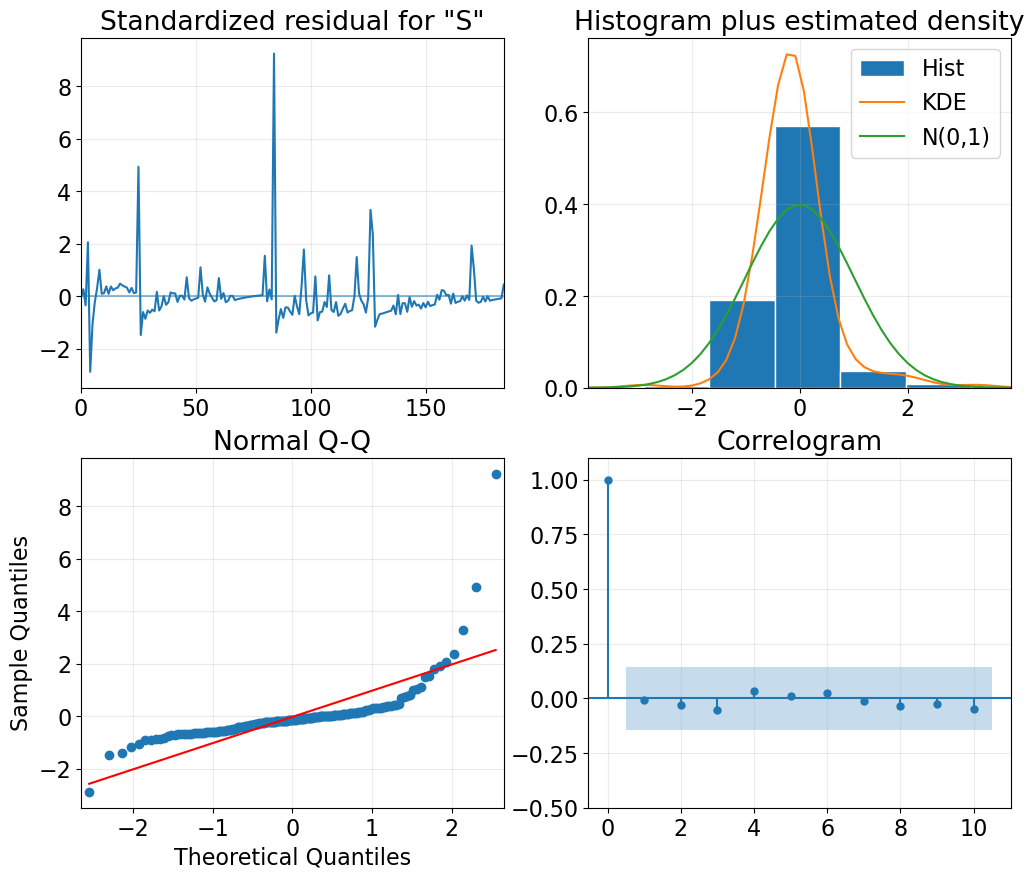

Plotting diagnostics for Varian G


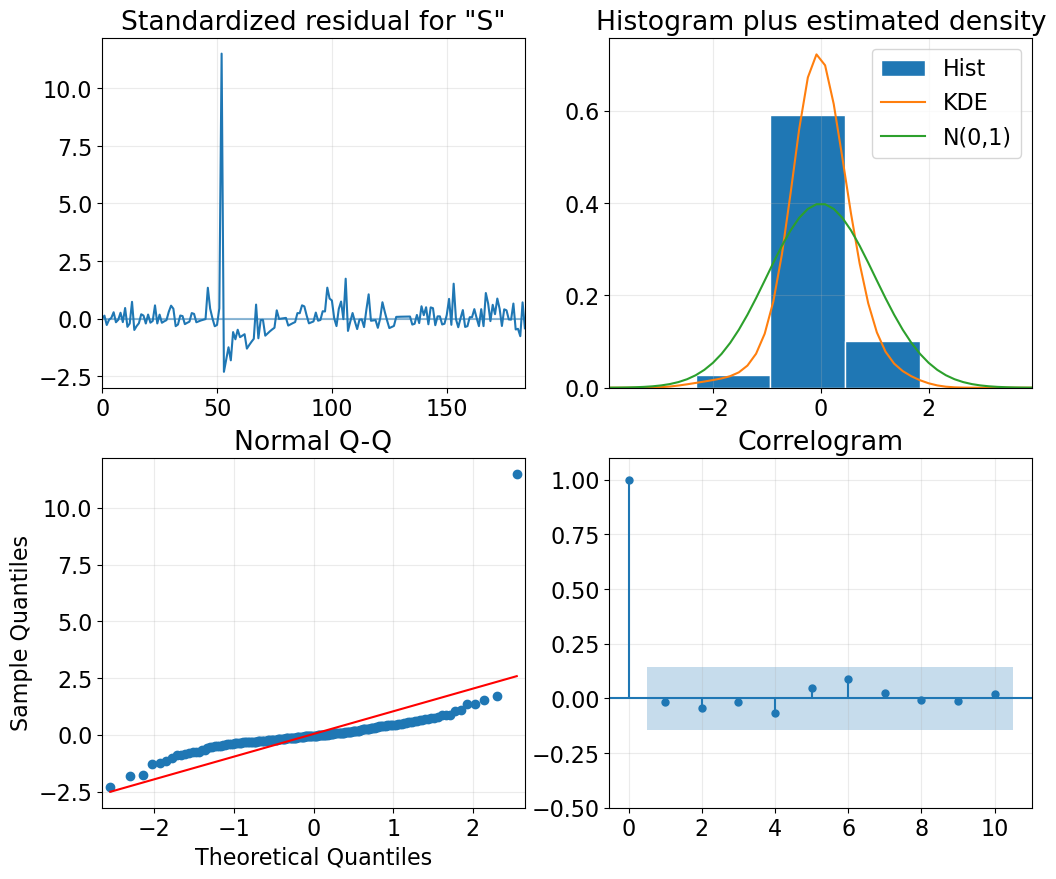

Plotting diagnostics for Varian H


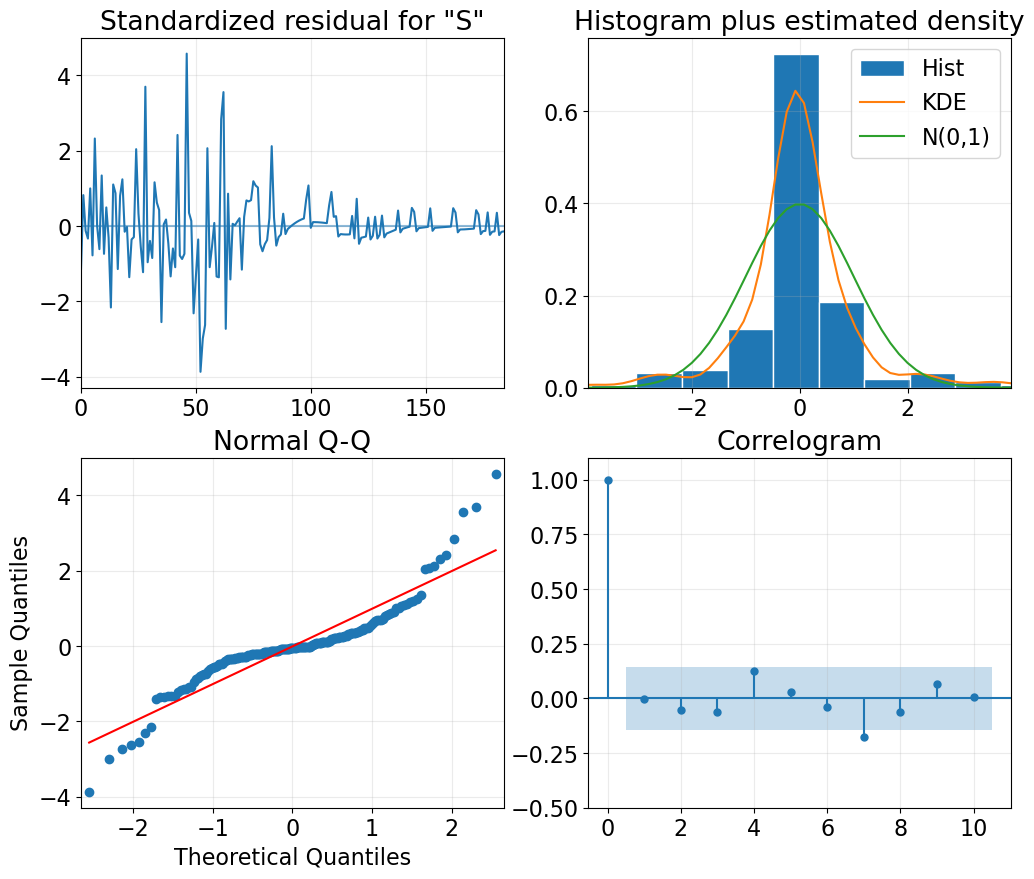

Plotting diagnostics for Varian M


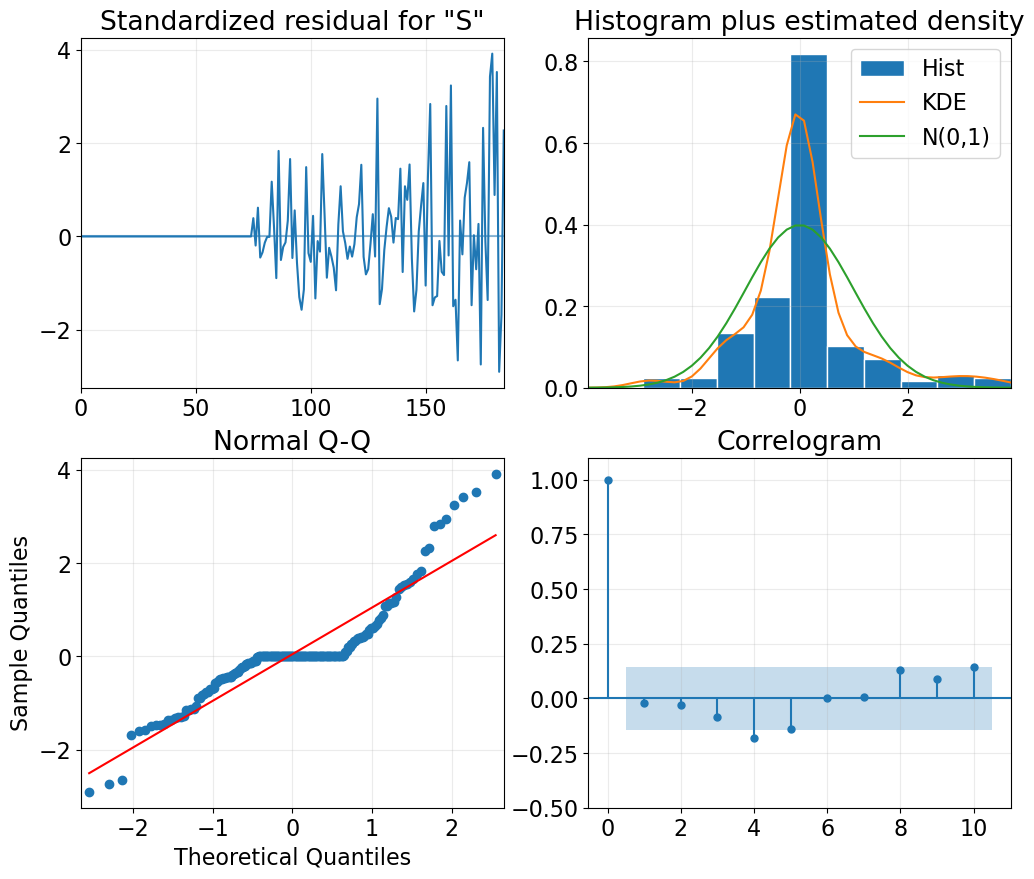

Plotting diagnostics for Varian L


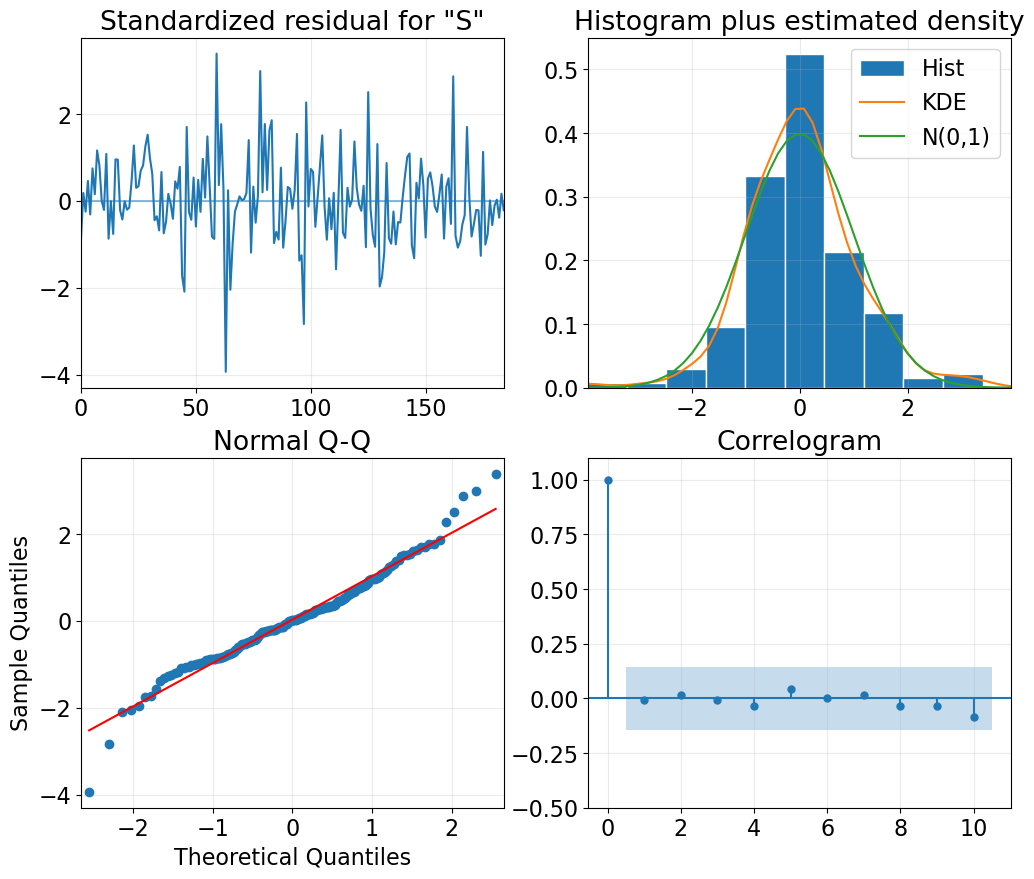

Plotting diagnostics for Varian J


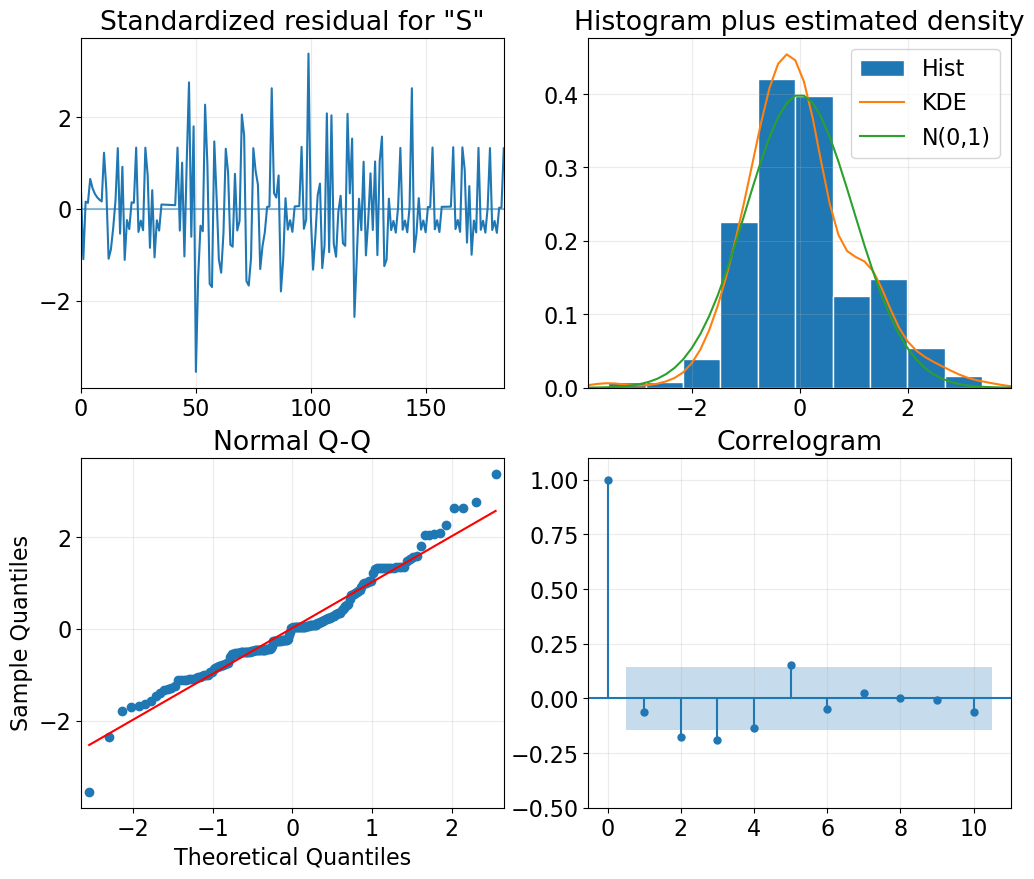

In [43]:
for varian, model_fit in models_arima_best.items():
    print(f"Plotting diagnostics for Varian {varian}")

    fig = model_fit.plot_diagnostics(figsize=(12, 10))

    # get all axes
    axs = fig.get_axes()
    for ax in axs:
        ax.grid("on")

    # set y-lim for correlogram plot
    axs[3].set_ylim([-0.5, 1.1])
    plt.show()


In [44]:
all_predictions = []

for varian, model_fit in models_arima_best.items():
    df_train = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian][["Date", "Sales"]].copy()
    df_test = df_weekly_varian_cum_diff[df_weekly_varian_cum_diff["Varian"] == varian][["Date", "Sales"]].copy()

    if df_test.empty:
        continue

    TRAIN_LEN = len(df_train)
    HORIZON = len(df_test)

    pred_mean = np.ones(HORIZON) * np.mean(df_train["Sales"])
    pred_naive_seasonal = df_train["Sales"].iloc[-HORIZON:].values
    pred_arima = model_fit.get_prediction(start=TRAIN_LEN, end=TRAIN_LEN + HORIZON - 1).predicted_mean

    df_test_pred = pd.DataFrame({
        "Date": df_test["Date"].values,
        "Varian": [varian] * HORIZON,
        "Actual": df_test["Sales"].values,
        "Pred_Mean": pred_mean,
        "Pred_Naive_Seasonal": pred_naive_seasonal,
        "Pred_ARIMA": pred_arima.values
    })

    print(df_test_pred.head())

    all_predictions.append(df_test_pred)

df_predictions = pd.concat(all_predictions, ignore_index=True)
df_predictions


        Date Varian  Actual  Pred_Mean  Pred_Naive_Seasonal  Pred_ARIMA
0 2021-02-01      E     0.0   0.010695                  0.0   -2.309493
1 2021-02-08      E     0.0   0.010695                  0.0   -0.201012
2 2021-02-15      E    -1.0   0.010695                 -1.0   -0.068771
3 2021-02-22      E     3.0   0.010695                  3.0   -0.061017
4 2021-03-01      E    -3.0   0.010695                 -3.0   -0.061105
        Date Varian  Actual  Pred_Mean  Pred_Naive_Seasonal  Pred_ARIMA
0 2021-02-01      G     0.0   0.005348                  0.0    1.140750
1 2021-02-08      G     0.0   0.005348                  0.0    0.026816
2 2021-02-15      G     0.0   0.005348                  0.0    0.033360
3 2021-02-22      G     1.0   0.005348                  1.0    0.034344
4 2021-03-01      G    -1.0   0.005348                 -1.0    0.035356
        Date Varian  Actual  Pred_Mean  Pred_Naive_Seasonal  Pred_ARIMA
0 2021-02-01      H     0.0   -0.02139                  0.0    0

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

,Date,Varian,Actual,Pred_Mean,Pred_Naive_Seasonal,Pred_ARIMA
0,2021-02-01,E,0.0,0.010695,0.0,-2.309493
1,2021-02-08,E,0.0,0.010695,0.0,-0.201012
2,2021-02-15,E,-1.0,0.010695,-1.0,-0.068771
3,2021-02-22,E,3.0,0.010695,3.0,-0.061017
4,2021-03-01,E,-3.0,0.010695,-3.0,-0.061105
...,...,...,...,...,...,...
1117,2024-07-29,J,0.0,0.005348,0.0,0.172011
1118,2024-08-05,J,0.0,0.005348,0.0,0.172967
1119,2024-08-12,J,0.0,0.005348,0.0,0.173923
1120,2024-08-19,J,0.0,0.005348,0.0,0.174879


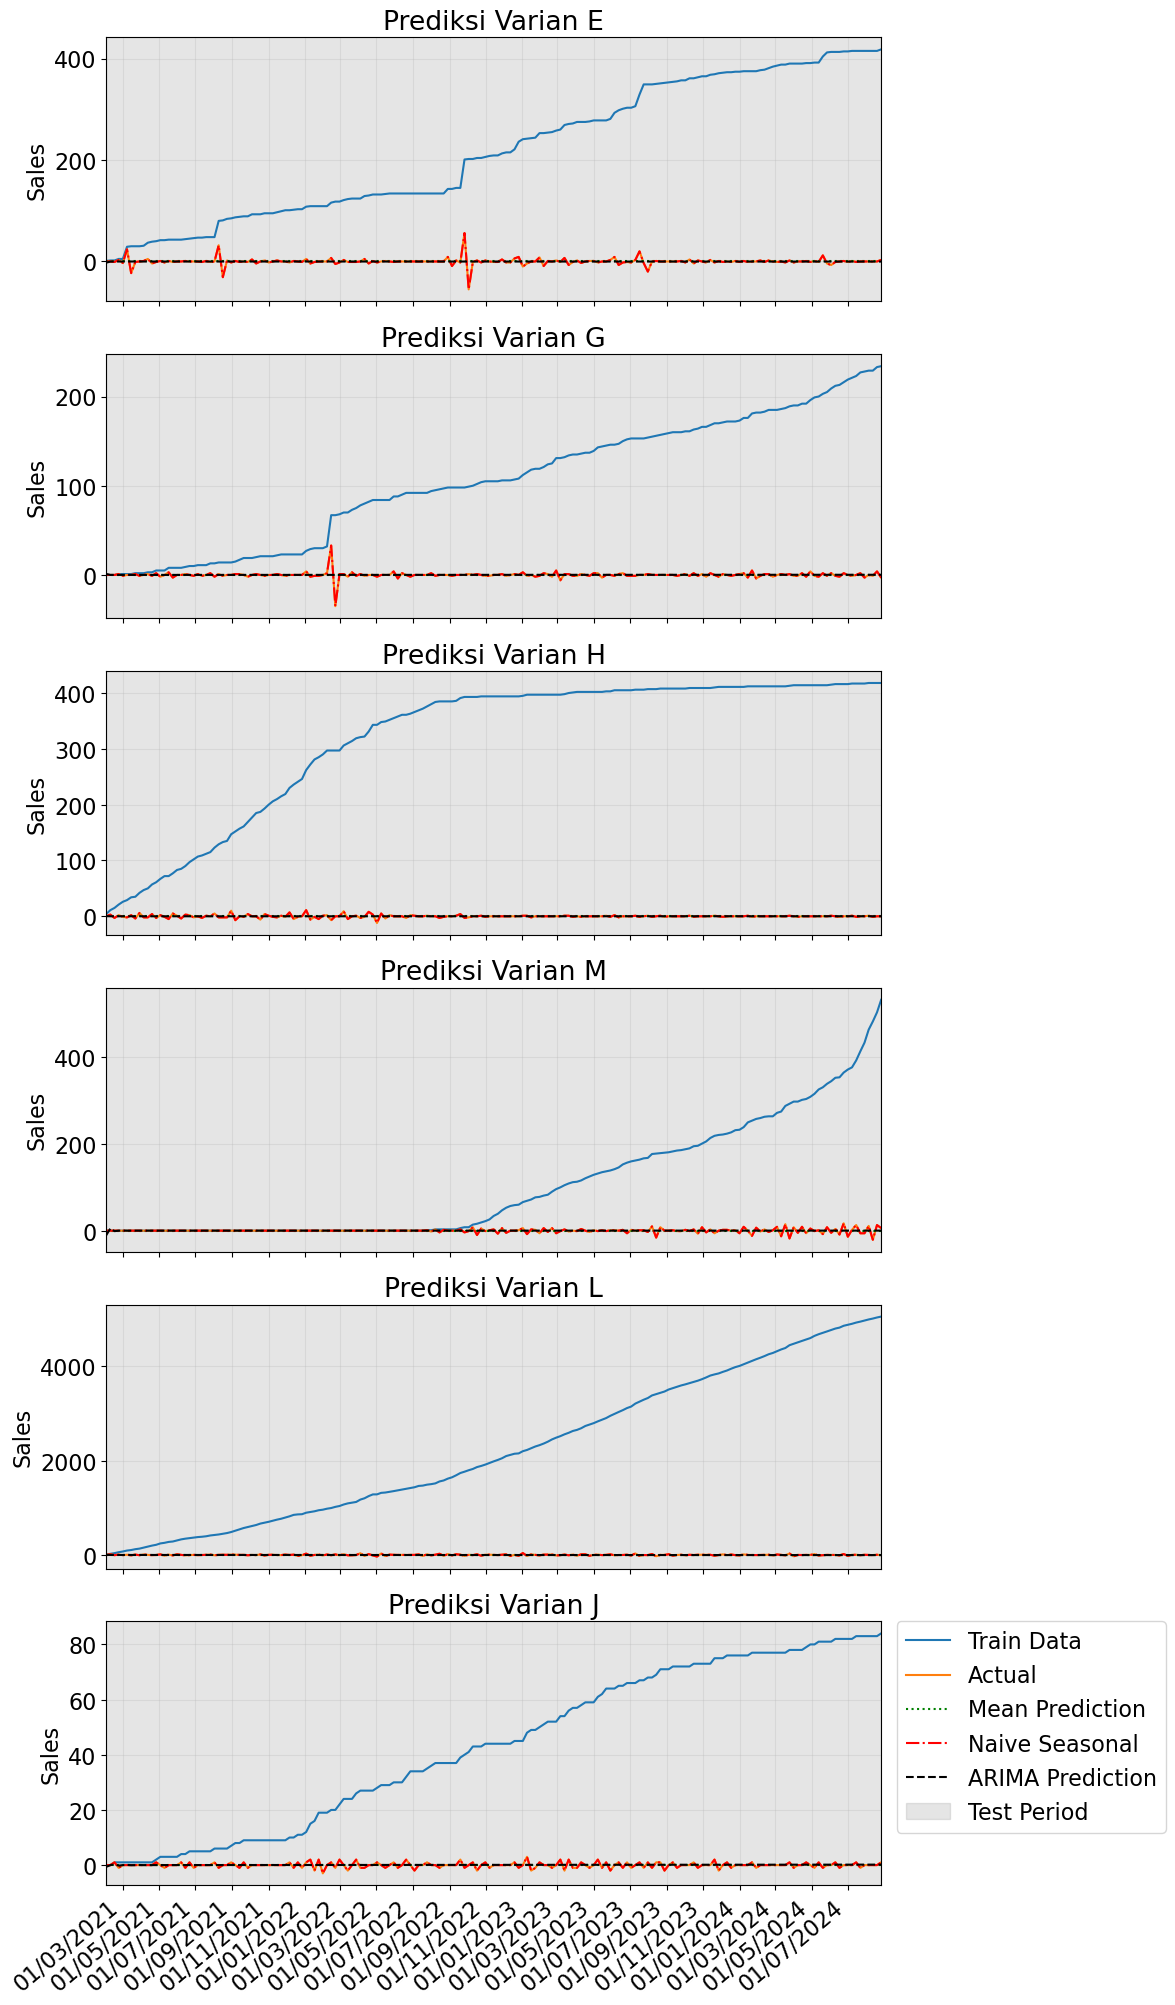

In [45]:
df_predictions["Date"] = pd.to_datetime(df_predictions["Date"])
df_weekly_varian_cum["Date"] = pd.to_datetime(df_weekly_varian_cum["Date"])

varian_list = df_predictions["Varian"].unique()

fig, axes = plt.subplots(nrows=len(varian_list), figsize=(10, 4 * len(varian_list)), sharex=True)

if len(varian_list) == 1:
    axes = [axes]

for ax, varian in zip(axes, varian_list):
    df_train = df_weekly_varian_cum[df_weekly_varian_cum["Varian"] == varian][["Date", "Sales"]].copy()
    df_test_pred = df_predictions[df_predictions["Varian"] == varian].copy()

    if df_train.empty or df_test_pred.empty:
        continue

    xlim = [df_train["Date"].iloc[0], df_test_pred["Date"].iloc[-1]]

    ax.plot(df_train["Date"], df_train["Sales"], label="Train Data", color="tab:blue")

    formatter = mdates.DateFormatter("%d/%m/%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)

    ax.set_xlim(xlim)
    ax.grid(True)
    ax.set_ylabel("Sales")
    ax.set_title(f"Prediksi Varian {varian}")
    
    # -- prediction
    ax.plot(df_test_pred["Date"], df_test_pred["Actual"], label="Actual", color="tab:orange")
    ax.plot(df_test_pred["Date"], df_test_pred["Pred_Mean"], "g:", label="Mean Prediction")
    ax.plot(df_test_pred["Date"], df_test_pred["Pred_Naive_Seasonal"], "r-.", label="Naive Seasonal")
    ax.plot(df_test_pred["Date"], df_test_pred["Pred_ARIMA"], "k--", label="ARIMA Prediction")

    # add forecast area
    ax.axvspan(df_test_pred['Date'].iloc[0], df_test_pred['Date'].iloc[-1], 
                color="#808080", alpha=0.2, label="Test Period")

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=40, ha="right")

# -- add legend in the second row
axes[-1].legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.show()


In [47]:
mae_mean           = mean_absolute_error(df_test_pred["Actual"], df_test_pred["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred["Actual"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["Actual"], df_test_pred["pred_arima"])

print(f"          MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"         MAE ARIMA: {mae_arima}")

KeyError: 'pred_mean'